### Flower Classification

In [1]:
# necessary libraries
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras import layers
from keras import models
from keras import optimizers
from keras import regularizers

from keras.models import Model, Sequential
from keras import layers

from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import VGG16


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16083123006167125109
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4174381056
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4861804879718300110
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1660 Ti with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [3]:
# visulization function for Models
def visualize(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    
    axs[0].plot(epochs, acc, 'r', label='Training acc')
    axs[0].plot(epochs, val_acc, 'b', label='Validation acc')
    axs[0].set_title('Training and validation accuracy')
    axs[0].legend()
    axs[0].grid(True)
    
    axs[1].plot(epochs, loss, 'r', label='Training loss')
    axs[1].plot(epochs, val_loss, 'b', label='Validation loss')
    axs[1].set_title('Training and validation loss')
    axs[1].legend()
    axs[1].grid(True)
    
    plt.tight_layout()
    plt.show()


## Prepare Dataset

In [4]:
 # use this function for preparing data 
training_dir="train"
validation_dir="validation"

def prep_data(augmented,batch_size=16):    
    if augmented:
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=40,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True)
    
        validation_datagen = ImageDataGenerator(rescale=1./255)    

    else:
        train_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
        validation_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

    # training set
    train_set = train_datagen.flow_from_directory(
        training_dir,
        target_size=(180, 180),  # The dimensions to which all images found will be resized
        seed=42,
        batch_size=batch_size,# 32  default
        class_mode="sparse") # you can change this to onehotEncoded format or another format
         
    
    # validation set
    validation_set = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(180, 180),
        seed=42,
        batch_size=batch_size,  # 32 default
        class_mode="sparse")
             
    return train_set , validation_set

In [5]:
# augmented train dataset
augmented_train_set,validation_set=prep_data(True)

Found 3019 images belonging to 5 classes.
Found 1298 images belonging to 5 classes.


In [6]:
# not augmented train set
straight_train_set,validation_set=prep_data(False)

Found 3019 images belonging to 5 classes.
Found 1298 images belonging to 5 classes.


### Distribution of Classes

In [7]:
import os
import matplotlib.pyplot as plt 

# Eğitim ve doğrulama setlerinin dizinleri
train_dir = training_dir
validation_dir = validation_dir

# Eğitim setindeki sınıf dağılımını hesapla
train_class_counts = {}
for class_folder in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_folder)
    if os.path.isdir(class_path):
        num_images = len(os.listdir(class_path))
        train_class_counts[class_folder] = num_images

# Doğrulama setindeki sınıf dağılımını hesapla
validation_class_counts = {}
for class_folder in os.listdir(validation_dir):
    class_path = os.path.join(validation_dir, class_folder)
    if os.path.isdir(class_path):
        num_images = len(os.listdir(class_path))
        validation_class_counts[class_folder] = num_images

print("Training set Distribution:")
print(train_class_counts)

print("Validation set Distribution:")
print(validation_class_counts)

Training set Distribution:
{'daisy': 534, 'dandelion': 736, 'rose': 548, 'sunflower': 513, 'tulip': 688}
Validation set Distribution:
{'daisy': 230, 'dandelion': 316, 'rose': 236, 'sunflower': 220, 'tulip': 296}


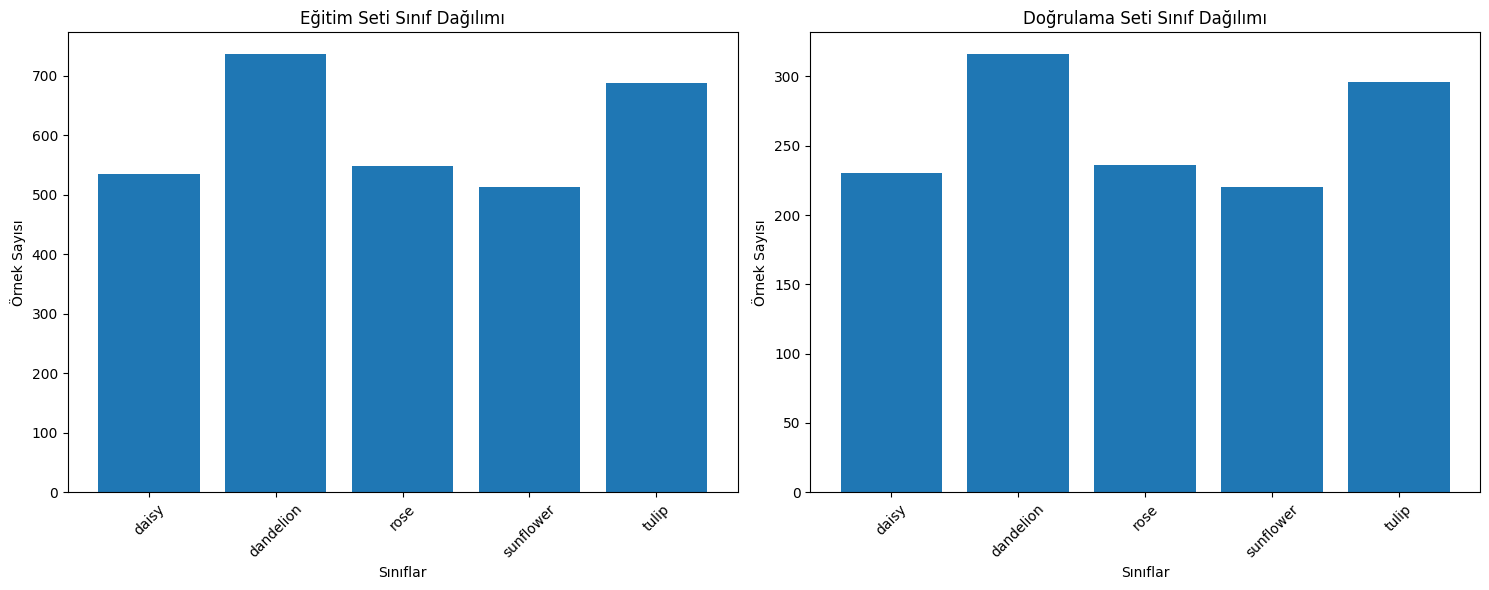

In [8]:
import matplotlib.pyplot as plt

# Eğitim seti sınıf dağılımı için bar grafik oluştur
plt.figure(figsize=(15, 6))

# Eğitim seti sınıf dağılımı için subplot 1
plt.subplot(1, 2, 1)
plt.bar(train_class_counts.keys(), train_class_counts.values())
plt.title('Eğitim Seti Sınıf Dağılımı')
plt.xlabel('Sınıflar')
plt.ylabel('Örnek Sayısı')
plt.xticks(rotation=45)

# Doğrulama seti sınıf dağılımı için subplot 2
plt.subplot(1, 2, 2)
plt.bar(validation_class_counts.keys(), validation_class_counts.values())
plt.title('Doğrulama Seti Sınıf Dağılımı')
plt.xlabel('Sınıflar')
plt.ylabel('Örnek Sayısı')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Some example images from  Train Dataset 

In [9]:
# not augmented dataset

images,labels=straight_train_set.next()

class_names = straight_train_set.class_indices
class_names = {v: k for k, v in class_names.items()}

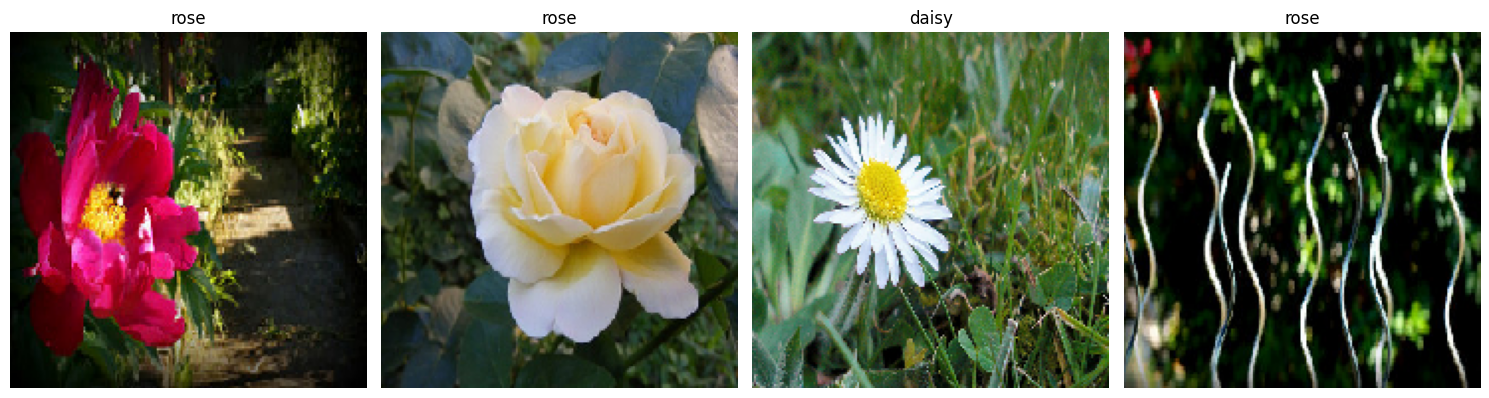

In [10]:
fig, axes = plt.subplots(1, 4, figsize=(15, 5))

for i in range(4):
    axes[i].imshow(images[i]) 
    label_index = int(labels[i])
    class_name = class_names[label_index]
    axes[i].set_title(f"{class_name}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Some Example Images from Augmented Train Dataset

In [11]:
# augmented dataset
images,labels=augmented_train_set.next()

class_names = augmented_train_set.class_indices
class_names = {v: k for k, v in class_names.items()}

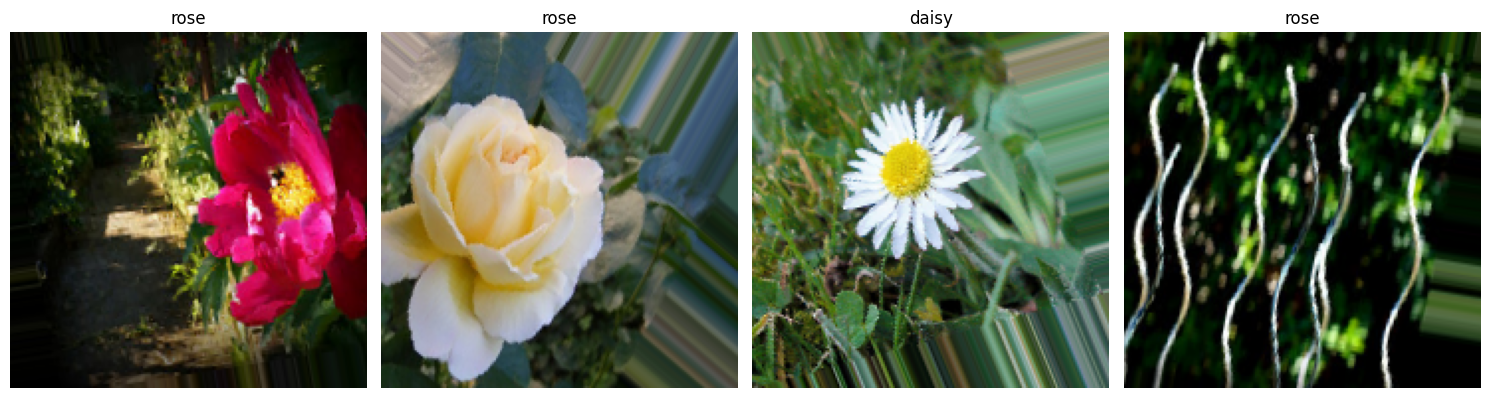

In [12]:
fig, axes = plt.subplots(1, 4, figsize=(15, 5))

for i in range(4):
    axes[i].imshow(images[i]) 
    label_index = int(labels[i])
    class_name = class_names[label_index]
    axes[i].set_title(f"{class_name}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## Model 1.1 CNN Model 

No Data Augmentation , 4Conv2D layer 

In [13]:
train_set,validation_set=prep_data(False) # create datasets (not augmented)

Found 3019 images belonging to 5 classes.
Found 1298 images belonging to 5 classes.


In [16]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(180, 180, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.Flatten())

model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(5, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 41, 41, 64)        36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 20, 20, 64)      

In [17]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=2e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

In [18]:
history1_1 = model.fit(
    train_set,
    epochs=20,
    validation_data=validation_set,)

Epoch 1/20
189/189 [==============================] - 19s 62ms/step - loss: 1.3848 - accuracy: 0.3760 - val_loss: 1.1710 - val_accuracy: 0.5254
Epoch 2/20
189/189 [==============================] - 7s 39ms/step - loss: 1.2217 - accuracy: 0.4899 - val_loss: 1.0291 - val_accuracy: 0.5948
Epoch 3/20
189/189 [==============================] - 7s 39ms/step - loss: 1.1203 - accuracy: 0.5601 - val_loss: 0.9685 - val_accuracy: 0.6094
Epoch 4/20
189/189 [==============================] - 7s 40ms/step - loss: 1.0231 - accuracy: 0.5995 - val_loss: 0.9285 - val_accuracy: 0.6233
Epoch 5/20
189/189 [==============================] - 7s 39ms/step - loss: 0.9704 - accuracy: 0.6390 - val_loss: 0.9578 - val_accuracy: 0.6117
Epoch 6/20
189/189 [==============================] - 7s 38ms/step - loss: 0.9181 - accuracy: 0.6645 - val_loss: 0.9034 - val_accuracy: 0.6510
Epoch 7/20
189/189 [==============================] - 7s 39ms/step - loss: 0.8570 - accuracy: 0.6853 - val_loss: 0.8487 - val_accuracy: 0.682

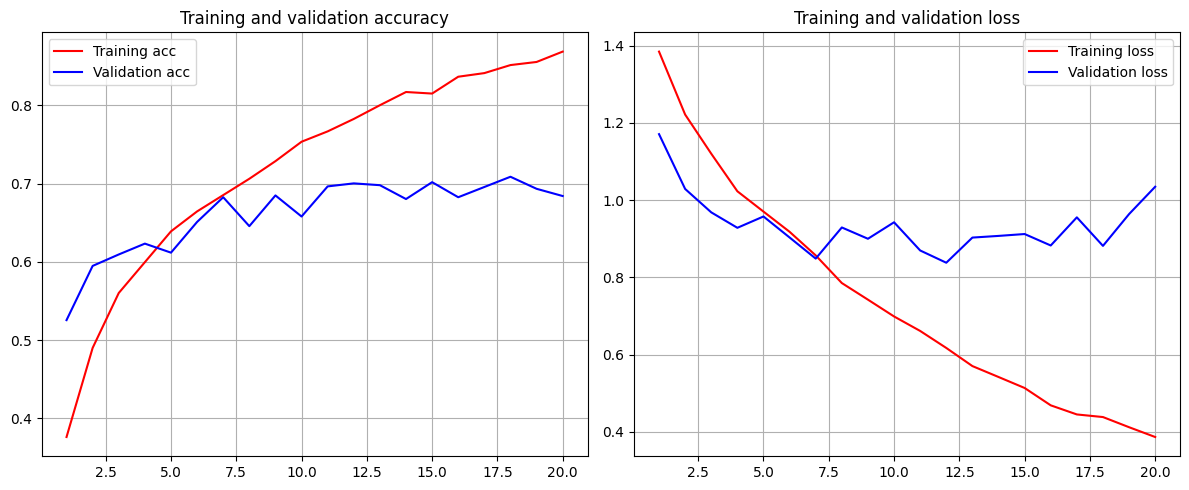

In [19]:
visualize(history1_1)

it clearly overfits , lets try to prevent overfitting with Data Augmentation

## Model 1.2 CNN Model with Data Augmentation

Model with Data Augmentation  , 3 Conv2D 

In [31]:
train_set,validation_set=prep_data(True) # create datasets ( augmented)

Found 3019 images belonging to 5 classes.
Found 1298 images belonging to 5 classes.


In [32]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(180, 180, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.Flatten())

model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(5, activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 43, 43, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 41, 41, 64)        36928     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 20, 20, 64)      

In [33]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=2e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

In [34]:
history1_2 = model.fit(
    train_set,
    epochs=25,
    validation_data=validation_set,)

Epoch 1/25
189/189 [==============================] - 21s 107ms/step - loss: 1.4525 - accuracy: 0.3345 - val_loss: 1.2342 - val_accuracy: 0.5131
Epoch 2/25
189/189 [==============================] - 20s 107ms/step - loss: 1.3076 - accuracy: 0.4568 - val_loss: 1.1980 - val_accuracy: 0.5008
Epoch 3/25
189/189 [==============================] - 20s 107ms/step - loss: 1.2450 - accuracy: 0.4899 - val_loss: 1.1190 - val_accuracy: 0.5555
Epoch 4/25
189/189 [==============================] - 20s 108ms/step - loss: 1.1644 - accuracy: 0.5386 - val_loss: 1.2775 - val_accuracy: 0.5485
Epoch 5/25
189/189 [==============================] - 20s 106ms/step - loss: 1.1339 - accuracy: 0.5658 - val_loss: 1.0975 - val_accuracy: 0.6140
Epoch 6/25
189/189 [==============================] - 20s 107ms/step - loss: 1.0910 - accuracy: 0.5863 - val_loss: 0.9908 - val_accuracy: 0.6348
Epoch 7/25
189/189 [==============================] - 20s 108ms/step - loss: 1.0456 - accuracy: 0.6042 - val_loss: 1.1241 - val_ac

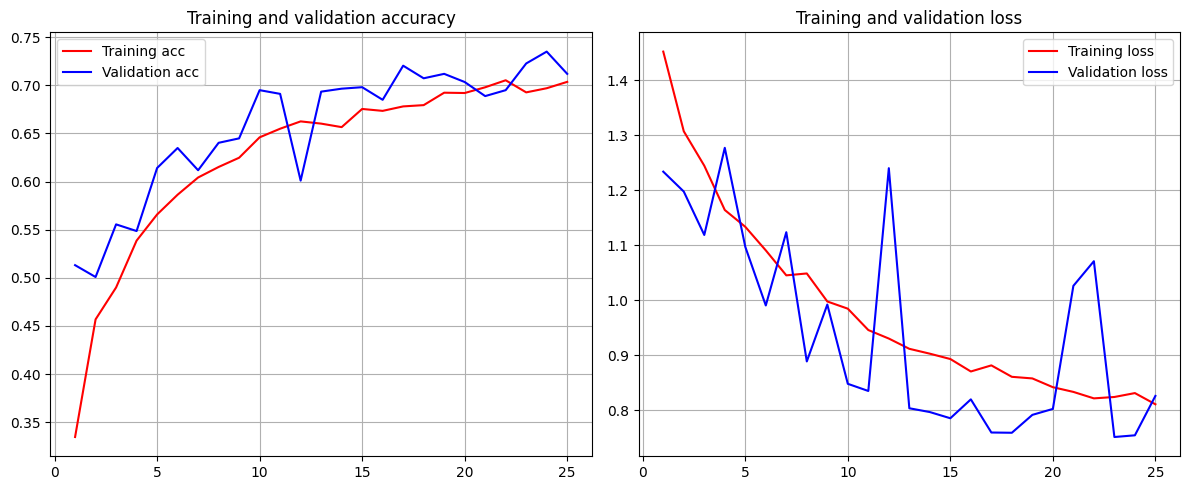

In [35]:
visualize(history1_2)

overfitting is gone for sure but accuracy drops down <br>
therefore i will try  more complex model  with adding more Conv2D Layer and <br>increase neuron number in last layer (layer that comes before dropout layer)

### Model 1.3 More Complex Model with data augmentation

Model with Data Augmentation <br> More neuron in some layers <br>More Conv2D Layer (6 Conv2D layer)

In [38]:
train_set,validation_set=prep_data(True) # create datasets ( augmented)

Found 3019 images belonging to 5 classes.
Found 1298 images belonging to 5 classes.


In [39]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(180, 180, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.Flatten())

model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(5, activation='softmax'))

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 43, 43, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_24 (Conv2D)          (None, 41, 41, 64)        36928     
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 20, 20, 64)      

In [40]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=2e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

In [41]:
history1_3 = model.fit(
    train_set,
    epochs=20,
    validation_data=validation_set,)

Epoch 1/20
189/189 [==============================] - 21s 108ms/step - loss: 1.4242 - accuracy: 0.3544 - val_loss: 1.1790 - val_accuracy: 0.5100
Epoch 2/20
189/189 [==============================] - 20s 106ms/step - loss: 1.2389 - accuracy: 0.4564 - val_loss: 1.1442 - val_accuracy: 0.5031
Epoch 3/20
189/189 [==============================] - 20s 108ms/step - loss: 1.1657 - accuracy: 0.5035 - val_loss: 1.1176 - val_accuracy: 0.5254
Epoch 4/20
189/189 [==============================] - 20s 108ms/step - loss: 1.0981 - accuracy: 0.5465 - val_loss: 1.0580 - val_accuracy: 0.5555
Epoch 5/20
189/189 [==============================] - 20s 108ms/step - loss: 1.0383 - accuracy: 0.5873 - val_loss: 0.9234 - val_accuracy: 0.6356
Epoch 6/20
189/189 [==============================] - 21s 109ms/step - loss: 1.0006 - accuracy: 0.6035 - val_loss: 0.9984 - val_accuracy: 0.5740
Epoch 7/20
189/189 [==============================] - 21s 109ms/step - loss: 0.9521 - accuracy: 0.6131 - val_loss: 0.9257 - val_ac

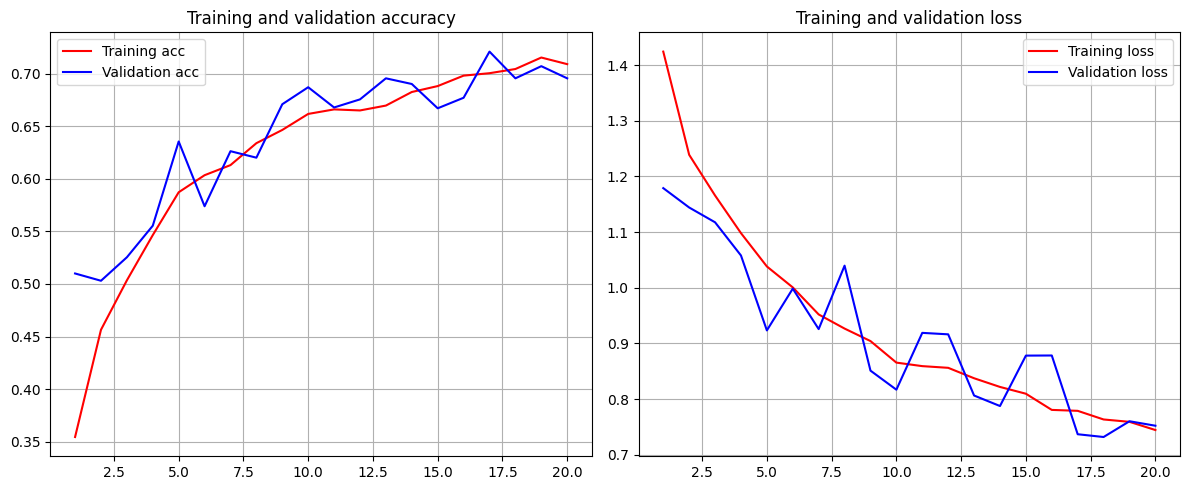

In [42]:
visualize(history1_3)

it didnt improve at all , i will try more complex models

## Model 2.2 Complex model with more  Neuron 

* Data augmentation <br> *2 Fully Connected Layer (256-512 neuron sequentially) <br>* 30 epoch <br> 2 Dropout Layer (0.2)

In [43]:
train_set,validation_set=prep_data(True) # create datasets ( augmented)

Found 3019 images belonging to 5 classes.
Found 1298 images belonging to 5 classes.


In [44]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(180, 180, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.Flatten())

model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(5, activation='softmax'))

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 43, 43, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_30 (Conv2D)          (None, 41, 41, 64)        36928     
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 20, 20, 64)      

In [45]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=2e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

In [46]:
history1_5 = model.fit(
    train_set,
    epochs=30,
    validation_data=validation_set,)

Epoch 1/30
189/189 [==============================] - 22s 109ms/step - loss: 1.4544 - accuracy: 0.3408 - val_loss: 1.2983 - val_accuracy: 0.4453
Epoch 2/30
189/189 [==============================] - 20s 107ms/step - loss: 1.2444 - accuracy: 0.4518 - val_loss: 1.1843 - val_accuracy: 0.4700
Epoch 3/30
189/189 [==============================] - 20s 107ms/step - loss: 1.1639 - accuracy: 0.5065 - val_loss: 1.1344 - val_accuracy: 0.4684
Epoch 4/30
189/189 [==============================] - 20s 106ms/step - loss: 1.1049 - accuracy: 0.5422 - val_loss: 1.0906 - val_accuracy: 0.5508
Epoch 5/30
189/189 [==============================] - 20s 108ms/step - loss: 1.0424 - accuracy: 0.5816 - val_loss: 1.0140 - val_accuracy: 0.5924
Epoch 6/30
189/189 [==============================] - 20s 106ms/step - loss: 0.9861 - accuracy: 0.6128 - val_loss: 0.9469 - val_accuracy: 0.6394
Epoch 7/30
189/189 [==============================] - 20s 106ms/step - loss: 0.9492 - accuracy: 0.6237 - val_loss: 0.9244 - val_ac

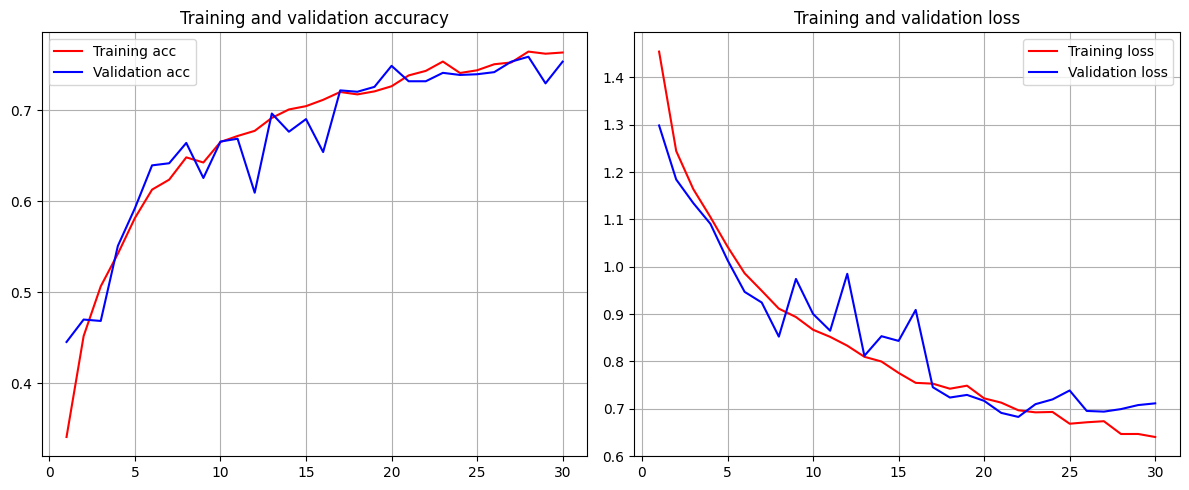

In [47]:
visualize(history1_5)

model is improved for sure  -->  accuracy: 0.7635

## Model 2.3 Deeper Model with 2 Dense Layer

* Data Augmentation <br>  More Filters in Conv2D <br> Reducing Dropout Rate(0.1)   

In [48]:
train_set,validation_set=prep_data(True) # create datasets ( augmented)

Found 3019 images belonging to 5 classes.
Found 1298 images belonging to 5 classes.


In [49]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(180, 180, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.Flatten())

model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.1))

model.add(layers.Dense(5, activation='softmax'))

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_34 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_35 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 43, 43, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_36 (Conv2D)          (None, 41, 41, 128)       73856     
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 20, 20, 128)     

In [50]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=2e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

In [51]:
history1_6 = model.fit(
    train_set,
    epochs=30,
    validation_data=validation_set,)

Epoch 1/30
189/189 [==============================] - 22s 108ms/step - loss: 1.4376 - accuracy: 0.3422 - val_loss: 1.2126 - val_accuracy: 0.4337
Epoch 2/30
189/189 [==============================] - 20s 106ms/step - loss: 1.2159 - accuracy: 0.4697 - val_loss: 1.1482 - val_accuracy: 0.4877
Epoch 3/30
189/189 [==============================] - 20s 108ms/step - loss: 1.1152 - accuracy: 0.5462 - val_loss: 1.0136 - val_accuracy: 0.5894
Epoch 4/30
189/189 [==============================] - 20s 108ms/step - loss: 1.0389 - accuracy: 0.5853 - val_loss: 0.9670 - val_accuracy: 0.6017
Epoch 5/30
189/189 [==============================] - 20s 108ms/step - loss: 0.9807 - accuracy: 0.6045 - val_loss: 1.5532 - val_accuracy: 0.5031
Epoch 6/30
189/189 [==============================] - 21s 110ms/step - loss: 0.9443 - accuracy: 0.6174 - val_loss: 0.8333 - val_accuracy: 0.6757
Epoch 7/30
189/189 [==============================] - 21s 110ms/step - loss: 0.9102 - accuracy: 0.6423 - val_loss: 0.9910 - val_ac

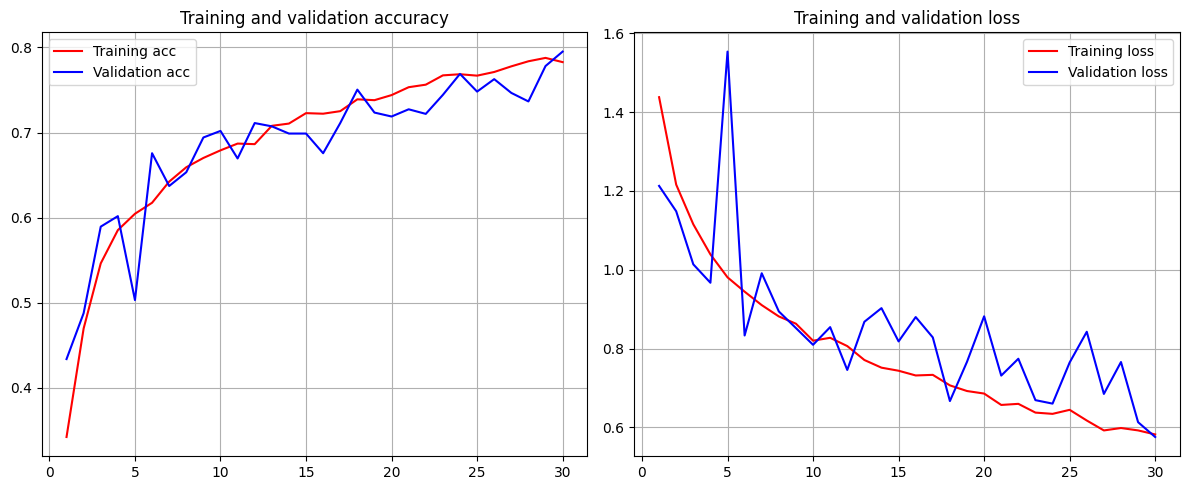

In [52]:
visualize(history1_6)

Model improved for sure --> accuracy: 0.7827  ,   val_accuracy: 0.7951

## Model 2.4 CNN Model with low learning rate more epoch

Same Model <br>
Lower learning rat <br>M
more epoch

In [58]:
train_set,validation_set=prep_data(True) # create datasets ( augmented)

Found 3019 images belonging to 5 classes.
Found 1298 images belonging to 5 classes.


In [59]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(180, 180, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.Flatten())

model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.1))

model.add(layers.Dense(5, activation='softmax'))

model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_46 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_37 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_47 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_38 (MaxPoolin  (None, 43, 43, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_48 (Conv2D)          (None, 41, 41, 128)       73856     
                                                                 
 max_pooling2d_39 (MaxPoolin  (None, 20, 20, 128)     

In [60]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.00005),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

In [61]:
history1_6 = model.fit(
    train_set,
    epochs=75,
    validation_data=validation_set,)

Epoch 1/75
189/189 [==============================] - 22s 109ms/step - loss: 1.5035 - accuracy: 0.3157 - val_loss: 1.2798 - val_accuracy: 0.4299
Epoch 2/75
189/189 [==============================] - 20s 107ms/step - loss: 1.2875 - accuracy: 0.4313 - val_loss: 1.1934 - val_accuracy: 0.4784
Epoch 3/75
189/189 [==============================] - 20s 108ms/step - loss: 1.2218 - accuracy: 0.4747 - val_loss: 1.1555 - val_accuracy: 0.5031
Epoch 4/75
189/189 [==============================] - 20s 108ms/step - loss: 1.1700 - accuracy: 0.5031 - val_loss: 1.0789 - val_accuracy: 0.5308
Epoch 5/75
189/189 [==============================] - 21s 110ms/step - loss: 1.1425 - accuracy: 0.5237 - val_loss: 1.0635 - val_accuracy: 0.5516
Epoch 6/75
189/189 [==============================] - 20s 107ms/step - loss: 1.0986 - accuracy: 0.5422 - val_loss: 1.0658 - val_accuracy: 0.5639
Epoch 7/75
189/189 [==============================] - 20s 106ms/step - loss: 1.0755 - accuracy: 0.5598 - val_loss: 1.0545 - val_ac

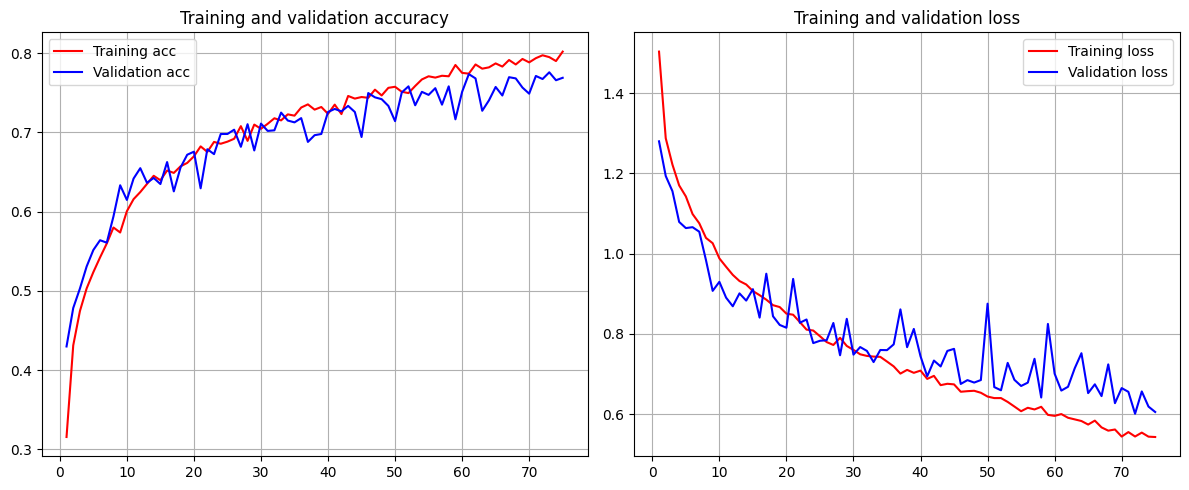

In [62]:
visualize(history1_6)

in below , i will try with more epoch and i will increase dropout rate to 0.25

## Model 2.4.1

125 epoch<br>
0.25 dropout

In [67]:
train_set,validation_set=prep_data(True) # create datasets ( augmented)

Found 3019 images belonging to 5 classes.
Found 1298 images belonging to 5 classes.


In [68]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(180, 180, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.Flatten())

model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.25))

model.add(layers.Dense(5, activation='softmax'))

model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_59 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_46 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_60 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_47 (MaxPoolin  (None, 43, 43, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_61 (Conv2D)          (None, 41, 41, 128)       73856     
                                                                 
 max_pooling2d_48 (MaxPoolin  (None, 20, 20, 128)    

In [69]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.00005),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

In [70]:
history1_6 = model.fit(
    train_set,
    epochs=125,
    validation_data=validation_set,)

Epoch 1/125
189/189 [==============================] - 23s 119ms/step - loss: 1.5819 - accuracy: 0.2733 - val_loss: 1.4554 - val_accuracy: 0.4230
Epoch 2/125
189/189 [==============================] - 21s 111ms/step - loss: 1.3619 - accuracy: 0.4028 - val_loss: 1.3769 - val_accuracy: 0.3798
Epoch 3/125
189/189 [==============================] - 21s 110ms/step - loss: 1.2616 - accuracy: 0.4472 - val_loss: 1.1771 - val_accuracy: 0.4923
Epoch 4/125
189/189 [==============================] - 21s 109ms/step - loss: 1.2126 - accuracy: 0.4813 - val_loss: 1.1011 - val_accuracy: 0.5139
Epoch 5/125
189/189 [==============================] - 20s 107ms/step - loss: 1.1795 - accuracy: 0.4965 - val_loss: 1.0951 - val_accuracy: 0.5308
Epoch 6/125
189/189 [==============================] - 21s 113ms/step - loss: 1.1533 - accuracy: 0.5141 - val_loss: 1.0515 - val_accuracy: 0.5601
Epoch 7/125
189/189 [==============================] - 22s 114ms/step - loss: 1.1125 - accuracy: 0.5366 - val_loss: 1.0271 -

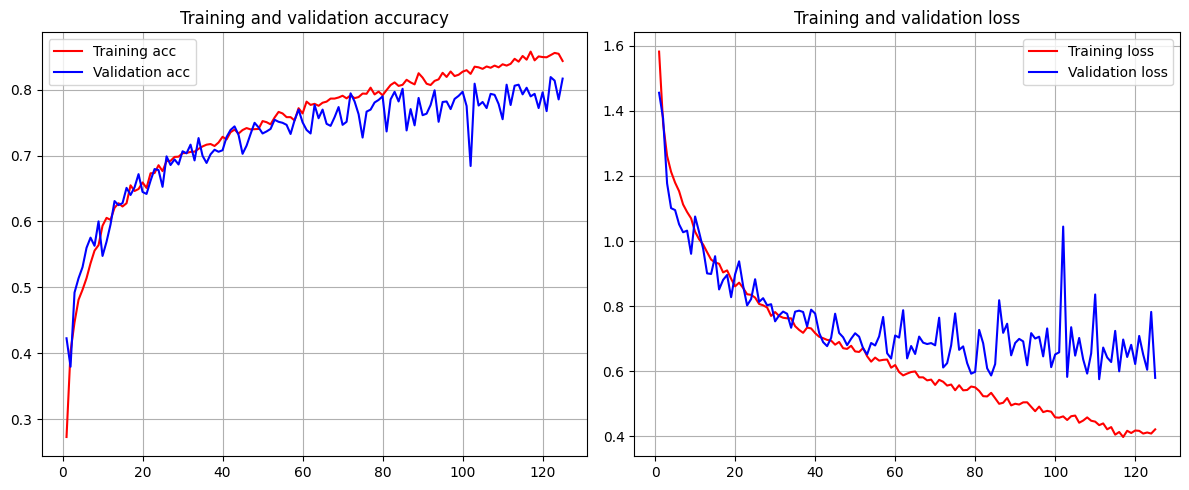

In [71]:
visualize(history1_6)

Model is litte bir overfitting but still improved

## Model 2.5 Different Arch. CNN Model 

Data Augmentation <br> There is no MaxPooling2D in between every Conv2D 

In [73]:
train_set,validation_set=prep_data(True) # create datasets ( augmented)

Found 3019 images belonging to 5 classes.
Found 1298 images belonging to 5 classes.


In [74]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(180, 180, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())

model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.1))

model.add(layers.Dense(5, activation='softmax'))

model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_65 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_51 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_66 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 conv2d_67 (Conv2D)          (None, 85, 85, 64)        36928     
                                                                 
 max_pooling2d_52 (MaxPoolin  (None, 42, 42, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_68 (Conv2D)          (None, 40, 40, 128)     

In [75]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=2e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

In [76]:
history1_7 = model.fit(
    train_set,
    epochs=30,
    validation_data=validation_set,)

Epoch 1/30
189/189 [==============================] - 26s 133ms/step - loss: 1.3917 - accuracy: 0.3779 - val_loss: 1.1958 - val_accuracy: 0.4769
Epoch 2/30
189/189 [==============================] - 22s 116ms/step - loss: 1.2230 - accuracy: 0.4617 - val_loss: 1.0699 - val_accuracy: 0.5532
Epoch 3/30
189/189 [==============================] - 21s 113ms/step - loss: 1.1414 - accuracy: 0.5234 - val_loss: 1.0204 - val_accuracy: 0.6079
Epoch 4/30
189/189 [==============================] - 21s 113ms/step - loss: 1.0491 - accuracy: 0.5836 - val_loss: 0.9994 - val_accuracy: 0.6248
Epoch 5/30
189/189 [==============================] - 20s 107ms/step - loss: 0.9964 - accuracy: 0.6201 - val_loss: 0.9151 - val_accuracy: 0.6471
Epoch 6/30
189/189 [==============================] - 21s 111ms/step - loss: 0.9667 - accuracy: 0.6320 - val_loss: 0.8572 - val_accuracy: 0.6710
Epoch 7/30
189/189 [==============================] - 22s 115ms/step - loss: 0.9315 - accuracy: 0.6469 - val_loss: 0.9209 - val_ac

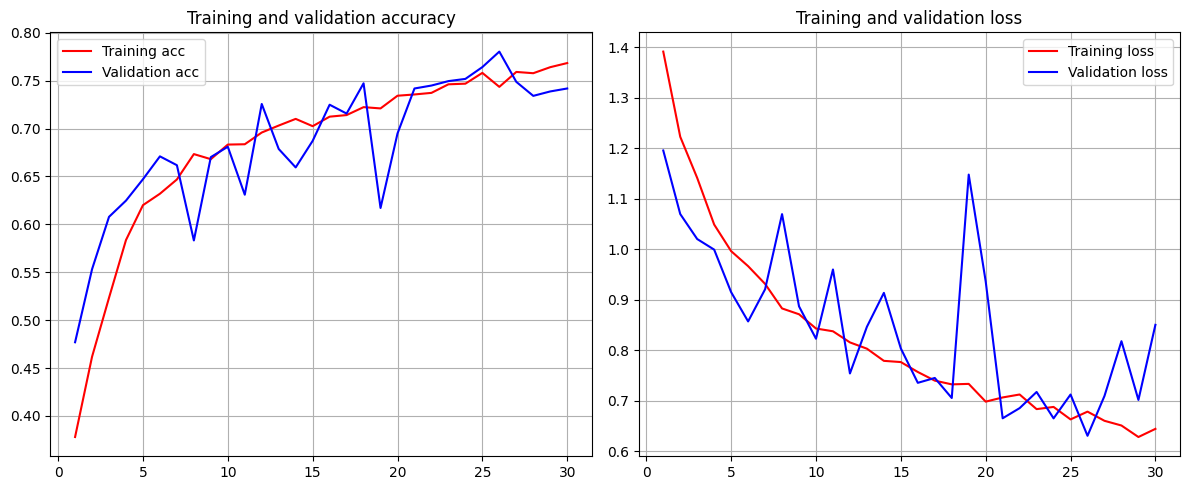

In [77]:
visualize(history1_7)

# Transfer Learning

What is Transfer Learning ? <br> This technique uses pre-trained models that have learned features from one task and applies them to a different but related task. By leveraging a pre-trained model's learned features, it's possible to boost performance on a new task with limited data.

1) Transfer Learning
2) Fine Tuning

First i will use VGG16 Model : Feature Extraction and Fine Tuning

## Pretrained Models

i am gonna use VGG16 model

## Model 3.1 VGG16 Feature Extraction 

No Data Augmentation <br>
One Fully Connected Layer with 128 layer <br>
Dropout rate is 0.5

In [79]:
from tensorflow.keras.applications import VGG16

In [80]:
train_set,validation_set=prep_data(False) 

Found 3019 images belonging to 5 classes.
Found 1298 images belonging to 5 classes.


In [81]:
conv_base = VGG16(
    weights='imagenet',   # one of None (random initialization), "imagenet" (pre-training on ImageNet), or the path to the weights file to be loaded.
    include_top=False,     #  whether to include the 3 fully-connected layers at the top of the network.
    input_shape=(180, 180, 3))

In [82]:
# in this part i am gonna do feature extraction therefore i set layers to untrainable
for layer in conv_base.layers:
     layer.trainable = False

conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

In [83]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(5, activation='softmax'))

In [84]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=2e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

In [128]:
history2_1 = model.fit(
    train_set,
    epochs=40,
    validation_data=validation_set,)

Epoch 1/40
189/189 [==============================] - 23s 112ms/step - loss: 1.0934 - accuracy: 0.5740 - val_loss: 0.7619 - val_accuracy: 0.7173
Epoch 2/40
189/189 [==============================] - 19s 101ms/step - loss: 0.7289 - accuracy: 0.7367 - val_loss: 0.6545 - val_accuracy: 0.7658
Epoch 3/40
189/189 [==============================] - 19s 101ms/step - loss: 0.5885 - accuracy: 0.7930 - val_loss: 0.6428 - val_accuracy: 0.7619
Epoch 4/40
189/189 [==============================] - 19s 101ms/step - loss: 0.4910 - accuracy: 0.8264 - val_loss: 0.6561 - val_accuracy: 0.7604
Epoch 5/40
189/189 [==============================] - 19s 101ms/step - loss: 0.4267 - accuracy: 0.8500 - val_loss: 0.6191 - val_accuracy: 0.7904
Epoch 6/40
189/189 [==============================] - 19s 101ms/step - loss: 0.3759 - accuracy: 0.8682 - val_loss: 0.6211 - val_accuracy: 0.7881
Epoch 7/40
189/189 [==============================] - 19s 101ms/step - loss: 0.3251 - accuracy: 0.8831 - val_loss: 0.6303 - val_ac

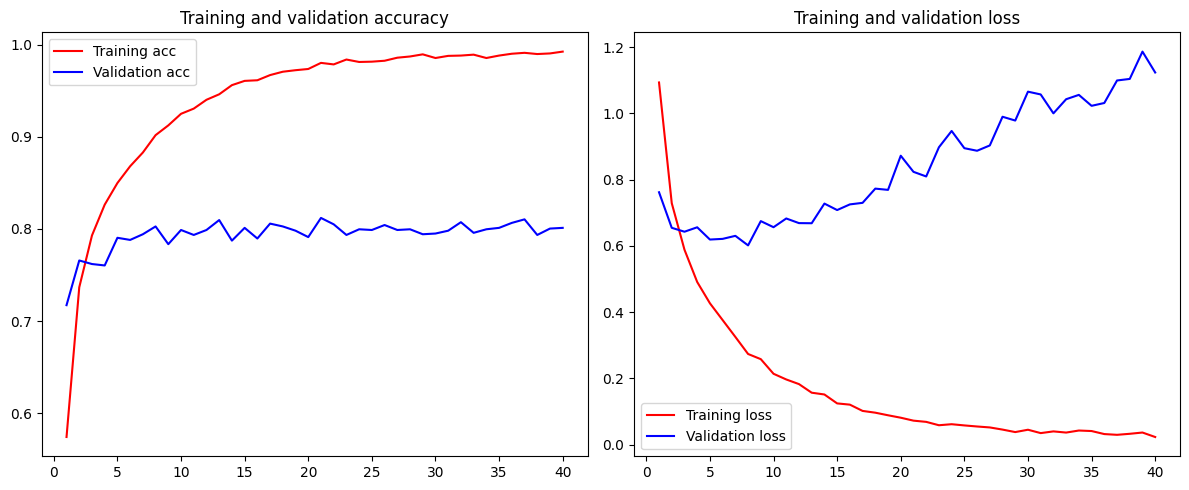

In [130]:
visualize(history2_1)

Model is clearly overfitting , i will use Data Augmentation to prevent it 

## Model 3.2 VGG16 Feature Extraction with data augmentation

Data Augmentation  <br>
1 Fully Connected Layer with 256 Neuron  <br>
Dropout Rate is 0.5

In [85]:
train_set,validation_set=prep_data(True) 

Found 3019 images belonging to 5 classes.
Found 1298 images belonging to 5 classes.


In [132]:
conv_base = VGG16(
    weights='imagenet',   # one of None (random initialization), "imagenet" (pre-training on ImageNet), or the path to the weights file to be loaded.
    include_top=False,     #  whether to include the 3 fully-connected layers at the top of the network.
    input_shape=(180, 180, 3))

In [133]:
# in this part i am gonna do feature extraction therefore i set layers to untrainable
for layer in conv_base.layers:
     layer.trainable = False

conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

In [134]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(5, activation='softmax'))

In [135]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=2e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

In [136]:
history2_2 = model.fit(
    train_set,
    epochs=40,
    validation_data=validation_set,)

Epoch 1/40
189/189 [==============================] - 25s 129ms/step - loss: 1.2072 - accuracy: 0.5492 - val_loss: 0.8188 - val_accuracy: 0.7103
Epoch 2/40
189/189 [==============================] - 24s 129ms/step - loss: 0.8888 - accuracy: 0.6767 - val_loss: 0.7234 - val_accuracy: 0.7334
Epoch 3/40
189/189 [==============================] - 25s 131ms/step - loss: 0.8233 - accuracy: 0.7082 - val_loss: 0.6540 - val_accuracy: 0.7727
Epoch 4/40
189/189 [==============================] - 25s 131ms/step - loss: 0.7562 - accuracy: 0.7277 - val_loss: 0.7100 - val_accuracy: 0.7704
Epoch 5/40
189/189 [==============================] - 25s 129ms/step - loss: 0.7467 - accuracy: 0.7314 - val_loss: 0.6051 - val_accuracy: 0.7820
Epoch 6/40
189/189 [==============================] - 24s 128ms/step - loss: 0.7101 - accuracy: 0.7406 - val_loss: 0.6428 - val_accuracy: 0.7812
Epoch 7/40
189/189 [==============================] - 24s 129ms/step - loss: 0.7054 - accuracy: 0.7453 - val_loss: 0.6207 - val_ac

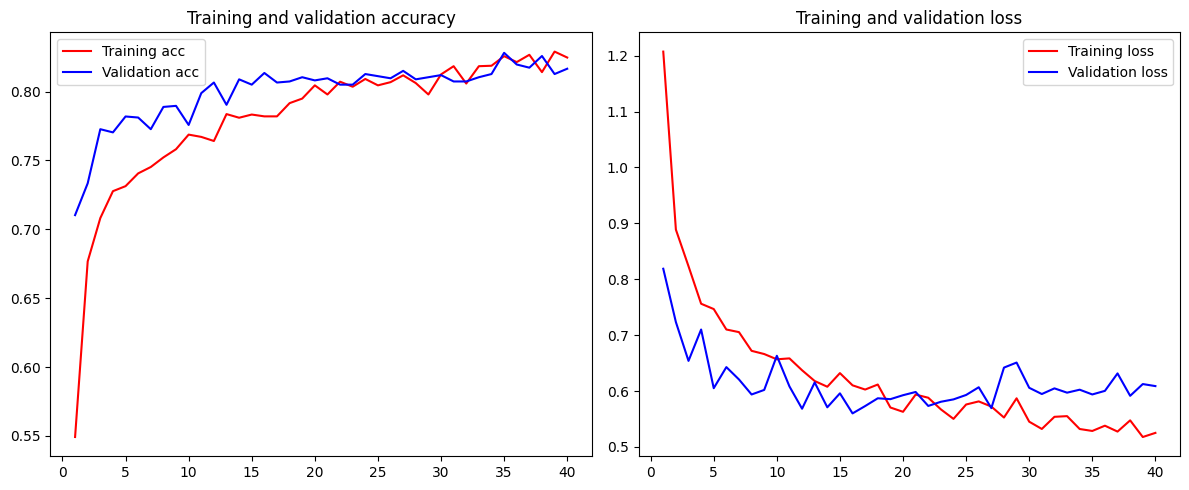

In [137]:
visualize(history2_2)

data augmentation worked , there is no overfitting in this model  , now i will try to increase model accuracy 

## Model 3.3  VGG16 Feature Extraction with data augmentation with More Layer

In [89]:
train_set,validation_set=prep_data(True,batch_size=16) 

Found 3019 images belonging to 5 classes.
Found 1298 images belonging to 5 classes.


In [90]:
conv_base = VGG16(
    weights='imagenet',   # one of None (random initialization), "imagenet" (pre-training on ImageNet), or the path to the weights file to be loaded.
    include_top=False,     #  whether to include the 3 fully-connected layers at the top of the network.
    input_shape=(180, 180, 3))

In [91]:
# in this part i am gonna do feature extraction therefore i set layers to untrainable
for layer in conv_base.layers:
     layer.trainable = False

conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

In [92]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(5, activation='softmax'))

In [93]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.00005),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

In [94]:
history2_3 = model.fit(
    train_set,
    epochs=100,
    validation_data=validation_set,)

Epoch 1/100
189/189 [==============================] - 33s 165ms/step - loss: 1.4775 - accuracy: 0.3716 - val_loss: 1.1544 - val_accuracy: 0.6179
Epoch 2/100
189/189 [==============================] - 24s 129ms/step - loss: 1.2118 - accuracy: 0.5144 - val_loss: 0.9665 - val_accuracy: 0.6356
Epoch 3/100
189/189 [==============================] - 24s 127ms/step - loss: 1.0629 - accuracy: 0.5889 - val_loss: 0.8418 - val_accuracy: 0.7134
Epoch 4/100
189/189 [==============================] - 24s 128ms/step - loss: 0.9752 - accuracy: 0.6343 - val_loss: 0.7942 - val_accuracy: 0.7211
Epoch 5/100
189/189 [==============================] - 24s 125ms/step - loss: 0.9005 - accuracy: 0.6621 - val_loss: 0.7241 - val_accuracy: 0.7404
Epoch 6/100
189/189 [==============================] - 26s 139ms/step - loss: 0.8507 - accuracy: 0.6800 - val_loss: 0.6964 - val_accuracy: 0.7442
Epoch 7/100
189/189 [==============================] - 25s 133ms/step - loss: 0.8084 - accuracy: 0.7022 - val_loss: 0.6909 -

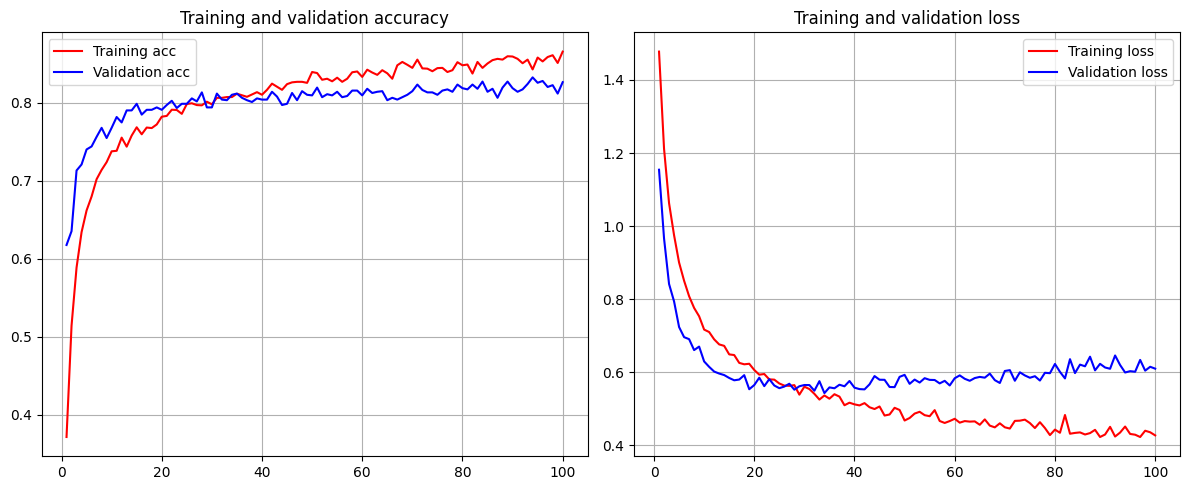

In [95]:
visualize(history2_3)

model is little bit overfitting but accuracy seems not bad

## Model 3.4 VGG16 (decreasing neuron number in last layers and i increased dropout values) 

In [177]:
train_set,validation_set=prep_data(True) 

Found 3019 images belonging to 5 classes.
Found 1298 images belonging to 5 classes.


In [178]:
conv_base = VGG16(
    weights='imagenet',   # one of None (random initialization), "imagenet" (pre-training on ImageNet), or the path to the weights file to be loaded.
    include_top=False,     #  whether to include the 3 fully-connected layers at the top of the network.
    input_shape=(180, 180, 3))

In [179]:
# in this part i am gonna do feature extraction therefore i set layers to untrainable
for layer in conv_base.layers:
     layer.trainable = False

conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

In [180]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(5, activation='softmax'))

In [181]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=2e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

In [182]:
history2_4 = model.fit(
    train_set,
    epochs=40,
    validation_data=validation_set,)

Epoch 1/40
189/189 [==============================] - 27s 137ms/step - loss: 1.3672 - accuracy: 0.4409 - val_loss: 0.9236 - val_accuracy: 0.6210
Epoch 2/40
189/189 [==============================] - 27s 144ms/step - loss: 1.0222 - accuracy: 0.6022 - val_loss: 0.7532 - val_accuracy: 0.7111
Epoch 3/40
189/189 [==============================] - 27s 141ms/step - loss: 0.9108 - accuracy: 0.6595 - val_loss: 0.6715 - val_accuracy: 0.7512
Epoch 4/40
189/189 [==============================] - 28s 149ms/step - loss: 0.8415 - accuracy: 0.6807 - val_loss: 0.6795 - val_accuracy: 0.7427
Epoch 5/40
189/189 [==============================] - 26s 138ms/step - loss: 0.7995 - accuracy: 0.7075 - val_loss: 0.6278 - val_accuracy: 0.7704
Epoch 6/40
189/189 [==============================] - 26s 139ms/step - loss: 0.7772 - accuracy: 0.7128 - val_loss: 0.6175 - val_accuracy: 0.7750
Epoch 7/40
189/189 [==============================] - 26s 135ms/step - loss: 0.7353 - accuracy: 0.7264 - val_loss: 0.6761 - val_ac

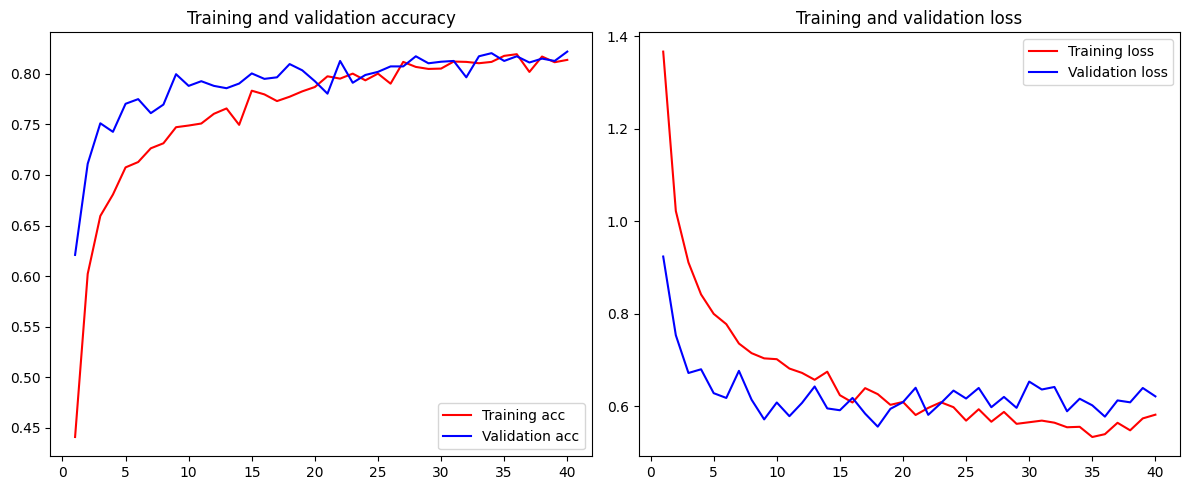

In [183]:
visualize(history2_4)

 accuracy: 0.8138 - val_accuracy: 0.8220

## Fine Tuning

## Model 4.1 Fine Tuning 

No Data Augmentation <br>
1 Fully Connected Layer with 128 neuron  <br>
Dropout Rate is 0.5

In [170]:
train_set,validation_set=prep_data(False,batch_size=16)

Found 3019 images belonging to 5 classes.
Found 1298 images belonging to 5 classes.


In [171]:
base_model = VGG16(weights='imagenet',
    include_top=False,
    input_shape=(180, 180, 3))

base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

In [172]:
# with block5_conv1 i will start to train model
# you can see block5_conv1 from above

base_model.trainable = True
set_trainable = False

for layer in base_model.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [173]:
model = Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(5, activation='softmax'))

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=2e-4),
    metrics=['accuracy']
)

model.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 flatten_26 (Flatten)        (None, 12800)             0         
                                                                 
 dense_61 (Dense)            (None, 128)               1638528   
                                                                 
 dropout_34 (Dropout)        (None, 128)               0         
                                                                 
 dense_62 (Dense)            (None, 5)                 645       
                                                                 
Total params: 16,353,861
Trainable params: 8,718,597
Non-trainable params: 7,635,264
_________________________________________________________________


In [174]:
fine_tune_11 = model.fit(
    train_set,
    epochs=40,
    validation_data=validation_set,
    )

Epoch 1/40
189/189 [==============================] - 23s 116ms/step - loss: 0.9978 - accuracy: 0.6168 - val_loss: 0.6946 - val_accuracy: 0.7334
Epoch 2/40
189/189 [==============================] - 22s 115ms/step - loss: 0.6284 - accuracy: 0.7880 - val_loss: 0.5665 - val_accuracy: 0.8243
Epoch 3/40
189/189 [==============================] - 22s 115ms/step - loss: 0.5468 - accuracy: 0.8380 - val_loss: 0.6106 - val_accuracy: 0.8089
Epoch 4/40
189/189 [==============================] - 22s 115ms/step - loss: 0.4711 - accuracy: 0.8582 - val_loss: 0.8557 - val_accuracy: 0.8405
Epoch 5/40
189/189 [==============================] - 22s 118ms/step - loss: 0.4192 - accuracy: 0.8771 - val_loss: 0.8844 - val_accuracy: 0.8328
Epoch 6/40
189/189 [==============================] - 22s 116ms/step - loss: 0.3653 - accuracy: 0.8960 - val_loss: 0.7717 - val_accuracy: 0.8328
Epoch 7/40
189/189 [==============================] - 22s 116ms/step - loss: 0.3552 - accuracy: 0.9119 - val_loss: 0.9261 - val_ac

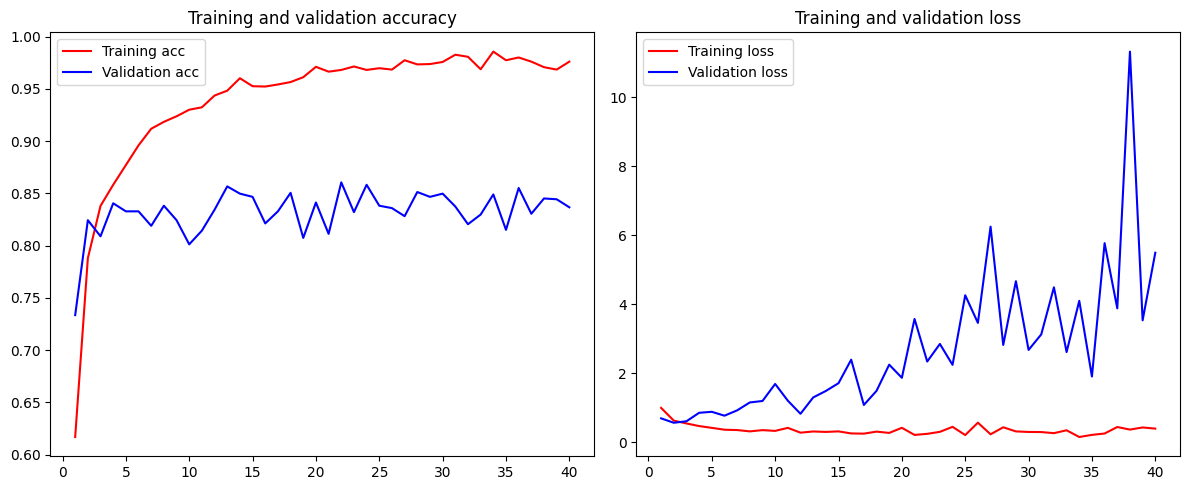

In [175]:
visualize(fine_tune_11)

model is overfitting for sure

## Model 4.2 Fine Tuning with Data Augmentation

Data Augmentation <br>
Train model after Layer block5_conv1<br>
0.00001 Learning Rate<br>
1 Fully Connected layer with 216 neuron

In [8]:
train_set,validation_set=prep_data(True)

Found 3019 images belonging to 5 classes.
Found 1298 images belonging to 5 classes.


In [9]:
base_model = VGG16(weights='imagenet',
    include_top=False,
    input_shape=(180, 180, 3))

base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

In [10]:
# with block5_conv1 i will start to train model
# you can see block5_conv1 from above

base_model.trainable = True
set_trainable = False

for layer in base_model.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [11]:
model = Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(5, activation='softmax'))

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.00001),
                                                        
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 12800)             0         
                                                                 
 dense (Dense)               (None, 64)                819264    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 325       
                                                                 
Total params: 15,534,277
Trainable params: 7,899,013
Non-trainable params: 7,635,264
_________________________________________________________________


In [12]:
fine_tune_12 = model.fit(
    train_set,
    epochs=27,
    validation_data=validation_set,
    )

Epoch 1/27
189/189 [==============================] - 38s 167ms/step - loss: 1.4888 - accuracy: 0.3614 - val_loss: 1.0807 - val_accuracy: 0.6333
Epoch 2/27
189/189 [==============================] - 24s 125ms/step - loss: 1.1019 - accuracy: 0.5707 - val_loss: 0.7830 - val_accuracy: 0.7188
Epoch 3/27
189/189 [==============================] - 24s 127ms/step - loss: 0.8922 - accuracy: 0.6645 - val_loss: 0.6893 - val_accuracy: 0.7419
Epoch 4/27
189/189 [==============================] - 24s 126ms/step - loss: 0.7649 - accuracy: 0.7175 - val_loss: 0.6388 - val_accuracy: 0.7704
Epoch 5/27
189/189 [==============================] - 24s 127ms/step - loss: 0.7032 - accuracy: 0.7486 - val_loss: 0.5467 - val_accuracy: 0.7935
Epoch 6/27
189/189 [==============================] - 24s 126ms/step - loss: 0.6509 - accuracy: 0.7546 - val_loss: 0.5048 - val_accuracy: 0.8128
Epoch 7/27
189/189 [==============================] - 24s 126ms/step - loss: 0.5832 - accuracy: 0.7923 - val_loss: 0.4888 - val_ac

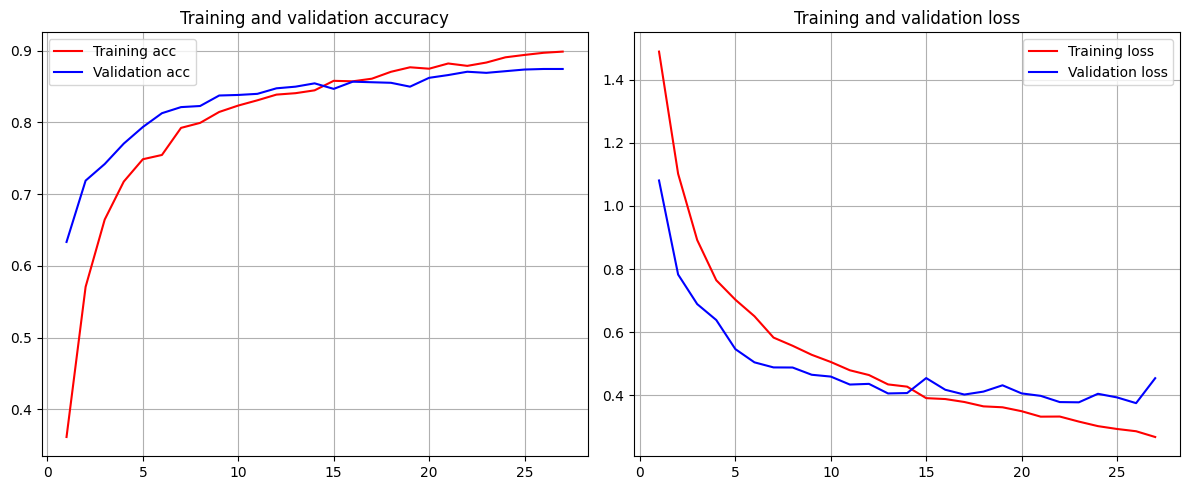

In [13]:
visualize(fine_tune_12)

This model seems pretty good 

## Other Transfer Learning Methods

## InceptionV3 Feature Extraction

Inception V3 Model <br>
1 Dense Layer with 256 neuron <br>
Dropout Rate is 0.4

In [14]:
train_set,validation_set=prep_data(True,batch_size=16) # with Data Augmentation

Found 3019 images belonging to 5 classes.
Found 1298 images belonging to 5 classes.


In [15]:
from tensorflow.keras.applications import InceptionV3

In [16]:
base_model = InceptionV3(weights='imagenet',
    include_top=False,
    input_shape=(180, 180, 3))


In [17]:
# in this part i am gonna do feature extraction therefore i set layers to untrainable
for layer in base_model.layers:
     layer.trainable = False

base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 89, 89, 32)   864         ['input_2[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 89, 89, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

In [18]:
model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(5, activation='softmax'))

In [19]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=2e-4),
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 4, 4, 2048)        21802784  
                                                                 
 flatten_1 (Flatten)         (None, 32768)             0         
                                                                 
 dense_2 (Dense)             (None, 256)               8388864   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 30,192,933
Trainable params: 8,390,149
Non-trainable params: 21,802,784
_________________________________________________________________


In [20]:
inception1_1 = model.fit(
    train_set,
    epochs=30,
    validation_data=validation_set,)

Epoch 1/30
189/189 [==============================] - 28s 127ms/step - loss: 1.8707 - accuracy: 0.6035 - val_loss: 0.7817 - val_accuracy: 0.7042
Epoch 2/30
189/189 [==============================] - 22s 114ms/step - loss: 0.9054 - accuracy: 0.6807 - val_loss: 0.5957 - val_accuracy: 0.7750
Epoch 3/30
189/189 [==============================] - 22s 115ms/step - loss: 0.8199 - accuracy: 0.7261 - val_loss: 0.5493 - val_accuracy: 0.8035
Epoch 4/30
189/189 [==============================] - 22s 117ms/step - loss: 0.7325 - accuracy: 0.7539 - val_loss: 0.5265 - val_accuracy: 0.8012
Epoch 5/30
189/189 [==============================] - 21s 109ms/step - loss: 0.7098 - accuracy: 0.7625 - val_loss: 0.5564 - val_accuracy: 0.8059
Epoch 6/30
189/189 [==============================] - 21s 112ms/step - loss: 0.6683 - accuracy: 0.7708 - val_loss: 0.5547 - val_accuracy: 0.8205
Epoch 7/30
189/189 [==============================] - 21s 111ms/step - loss: 0.6804 - accuracy: 0.7820 - val_loss: 0.5086 - val_ac

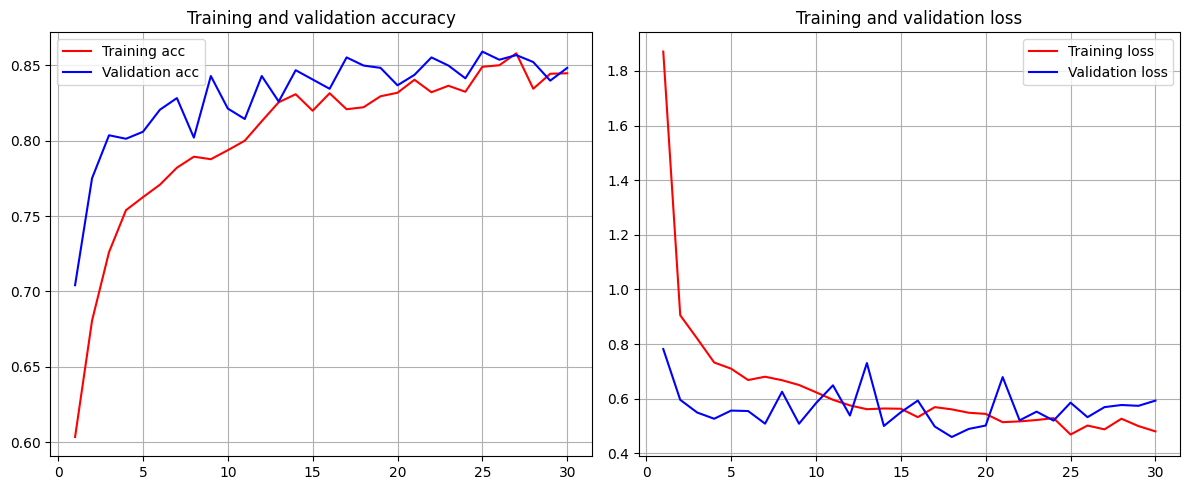

In [21]:
visualize(inception1_1)

## InceptionV3 More complex Model (neuron num and dense layer)

Data Augmentation <br>
2 Fully Connected Layer with (128-256 neuron sequentially) <br>
0.5 Dropout Rate <br>
Lower Learning Rate and more Epoch

In [44]:
train_set,validation_set=prep_data(True,batch_size=16) # with Data Augmentation

Found 3019 images belonging to 5 classes.
Found 1298 images belonging to 5 classes.


In [45]:
base_model = InceptionV3(weights='imagenet',
    include_top=False,
    input_shape=(180, 180, 3))

In [46]:
# in this part i am gonna do feature extraction therefore i set layers to untrainable
for layer in base_model.layers:
     layer.trainable = False

base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_376 (Conv2D)            (None, 89, 89, 32)   864         ['input_6[0][0]']                
                                                                                                  
 batch_normalization_376 (Batch  (None, 89, 89, 32)  96          ['conv2d_376[0][0]']             
 Normalization)                                                                                   
                                                                                       

In [47]:
model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(5, activation='softmax'))

In [48]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.00005),
    metrics=['accuracy']
)

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 4, 4, 2048)        21802784  
                                                                 
 flatten_5 (Flatten)         (None, 32768)             0         
                                                                 
 dense_13 (Dense)            (None, 128)               4194432   
                                                                 
 dropout_8 (Dropout)         (None, 128)               0         
                                                                 
 dense_14 (Dense)            (None, 256)               33024     
                                                                 
 dropout_9 (Dropout)         (None, 256)               0         
                                                                 
 dense_15 (Dense)            (None, 5)                

In [49]:
inception1_2 = model.fit(
    train_set,
    epochs=65,
    validation_data=validation_set,)

Epoch 1/65
189/189 [==============================] - 28s 124ms/step - loss: 1.4937 - accuracy: 0.3879 - val_loss: 0.8880 - val_accuracy: 0.6703
Epoch 2/65
189/189 [==============================] - 22s 117ms/step - loss: 1.1725 - accuracy: 0.5406 - val_loss: 0.7569 - val_accuracy: 0.7334
Epoch 3/65
189/189 [==============================] - 23s 124ms/step - loss: 1.0348 - accuracy: 0.5879 - val_loss: 0.7791 - val_accuracy: 0.7304
Epoch 4/65
189/189 [==============================] - 23s 123ms/step - loss: 0.9193 - accuracy: 0.6555 - val_loss: 0.6236 - val_accuracy: 0.7974
Epoch 5/65
189/189 [==============================] - 23s 123ms/step - loss: 0.8942 - accuracy: 0.6681 - val_loss: 0.6098 - val_accuracy: 0.7935
Epoch 6/65
189/189 [==============================] - 25s 130ms/step - loss: 0.8483 - accuracy: 0.6850 - val_loss: 0.5480 - val_accuracy: 0.8213
Epoch 7/65
189/189 [==============================] - 25s 131ms/step - loss: 0.8043 - accuracy: 0.7092 - val_loss: 0.5120 - val_ac

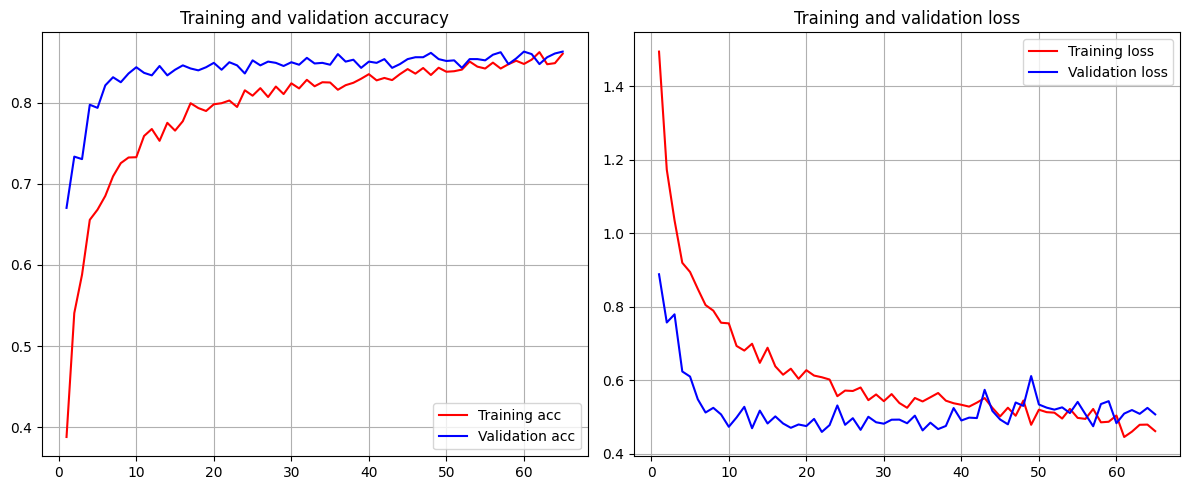

In [50]:
visualize(inception1_2)

this model seems better <br>
accuracy: 0.8602 - val_loss: 0.5069 - val_accuracy: 0.8629

## InceptionV3 Feature Extraction without Data Augmentation

In [73]:
train_set,validation_set=prep_data(False,batch_size=16) # with Data Augmentation

Found 3019 images belonging to 5 classes.
Found 1298 images belonging to 5 classes.


In [74]:
base_model = InceptionV3(weights='imagenet',
    include_top=False,
    input_shape=(180, 180, 3))

In [75]:
# in this part i am gonna do feature extraction therefore i set layers to untrainable
for layer in base_model.layers:
     layer.trainable = False

base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_752 (Conv2D)            (None, 89, 89, 32)   864         ['input_10[0][0]']               
                                                                                                  
 batch_normalization_752 (Batch  (None, 89, 89, 32)  96          ['conv2d_752[0][0]']             
 Normalization)                                                                                   
                                                                                       

In [76]:

model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(5, activation='softmax'))

In [77]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), # 0.001 default
    metrics=['accuracy']
)

model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 4, 4, 2048)        21802784  
                                                                 
 flatten_9 (Flatten)         (None, 32768)             0         
                                                                 
 dense_23 (Dense)            (None, 64)                2097216   
                                                                 
 dropout_14 (Dropout)        (None, 64)                0         
                                                                 
 dense_24 (Dense)            (None, 5)                 325       
                                                                 
Total params: 23,900,325
Trainable params: 2,097,541
Non-trainable params: 21,802,784
_________________________________________________________________


In [78]:
inception1_3 = model.fit(
    train_set,
    epochs=50,
    validation_data=validation_set,)

Epoch 1/50
189/189 [==============================] - 14s 57ms/step - loss: 1.1548 - accuracy: 0.5783 - val_loss: 0.7490 - val_accuracy: 0.7442
Epoch 2/50
189/189 [==============================] - 9s 48ms/step - loss: 0.7523 - accuracy: 0.7228 - val_loss: 0.5348 - val_accuracy: 0.8197
Epoch 3/50
189/189 [==============================] - 10s 53ms/step - loss: 0.6259 - accuracy: 0.7781 - val_loss: 0.4882 - val_accuracy: 0.8328
Epoch 4/50
189/189 [==============================] - 10s 53ms/step - loss: 0.5285 - accuracy: 0.8155 - val_loss: 0.4951 - val_accuracy: 0.8290
Epoch 5/50
189/189 [==============================] - 10s 51ms/step - loss: 0.4446 - accuracy: 0.8357 - val_loss: 0.5045 - val_accuracy: 0.8344
Epoch 6/50
189/189 [==============================] - 10s 53ms/step - loss: 0.4076 - accuracy: 0.8586 - val_loss: 0.4973 - val_accuracy: 0.8282
Epoch 7/50
189/189 [==============================] - 9s 48ms/step - loss: 0.3604 - accuracy: 0.8738 - val_loss: 0.4859 - val_accuracy: 0

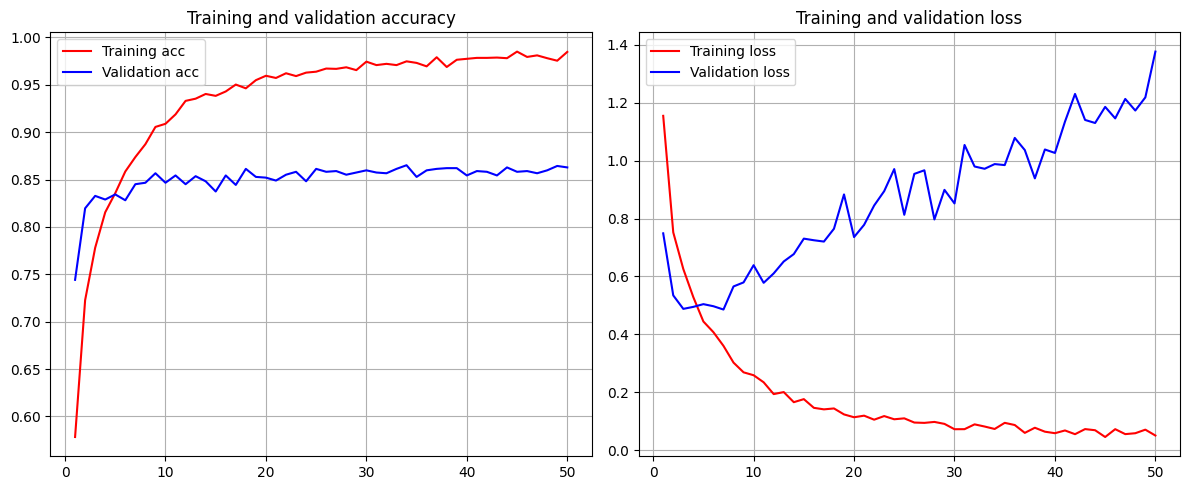

In [80]:
visualize(inception1_3)

overfitting occured , beacuse we didnt use data augmentation

## Fine Tuning with InceptionV3

Data augmentation <br>
Train pretrained model InceptionV3's  last 10 layer <br>
2 Fully Connected Layer <br>
0.2 Dropout Rate (1 Dropout Layer used)

In [81]:
train_set,validation_set=prep_data(True,batch_size=16) # with Data Augmentation

Found 3019 images belonging to 5 classes.
Found 1298 images belonging to 5 classes.


In [82]:
base_model = InceptionV3(weights='imagenet',
    include_top=False,
    input_shape=(180, 180, 3))

In [83]:
# Freeze the layers except the last few layers
for layer in base_model.layers[:-10]:
    layer.trainable = False

In [84]:
model = Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=2e-4),
    metrics=['accuracy']
)

model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 4, 4, 2048)        21802784  
                                                                 
 flatten_10 (Flatten)        (None, 32768)             0         
                                                                 
 dense_25 (Dense)            (None, 128)               4194432   
                                                                 
 dropout_15 (Dropout)        (None, 128)               0         
                                                                 
 dense_26 (Dense)            (None, 256)               33024     
                                                                 
 dense_27 (Dense)            (None, 5)                 1285      
                                                                 
Total params: 26,031,525
Trainable params: 4,228,933


In [85]:
fine_tune_inception1_1 = model.fit(
    train_set,
    epochs=40,
    validation_data=validation_set,
    )

Epoch 1/40
189/189 [==============================] - 26s 117ms/step - loss: 1.1864 - accuracy: 0.6019 - val_loss: 0.6177 - val_accuracy: 0.7604
Epoch 2/40
189/189 [==============================] - 23s 121ms/step - loss: 0.7591 - accuracy: 0.7340 - val_loss: 0.7289 - val_accuracy: 0.7388
Epoch 3/40
189/189 [==============================] - 22s 115ms/step - loss: 0.6864 - accuracy: 0.7559 - val_loss: 0.6011 - val_accuracy: 0.7920
Epoch 4/40
189/189 [==============================] - 22s 116ms/step - loss: 0.6261 - accuracy: 0.7767 - val_loss: 0.4986 - val_accuracy: 0.8236
Epoch 5/40
189/189 [==============================] - 21s 111ms/step - loss: 0.6208 - accuracy: 0.7834 - val_loss: 0.5548 - val_accuracy: 0.8197
Epoch 6/40
189/189 [==============================] - 22s 114ms/step - loss: 0.5690 - accuracy: 0.8069 - val_loss: 0.5243 - val_accuracy: 0.8259
Epoch 7/40
189/189 [==============================] - 22s 117ms/step - loss: 0.5563 - accuracy: 0.8052 - val_loss: 0.5464 - val_ac

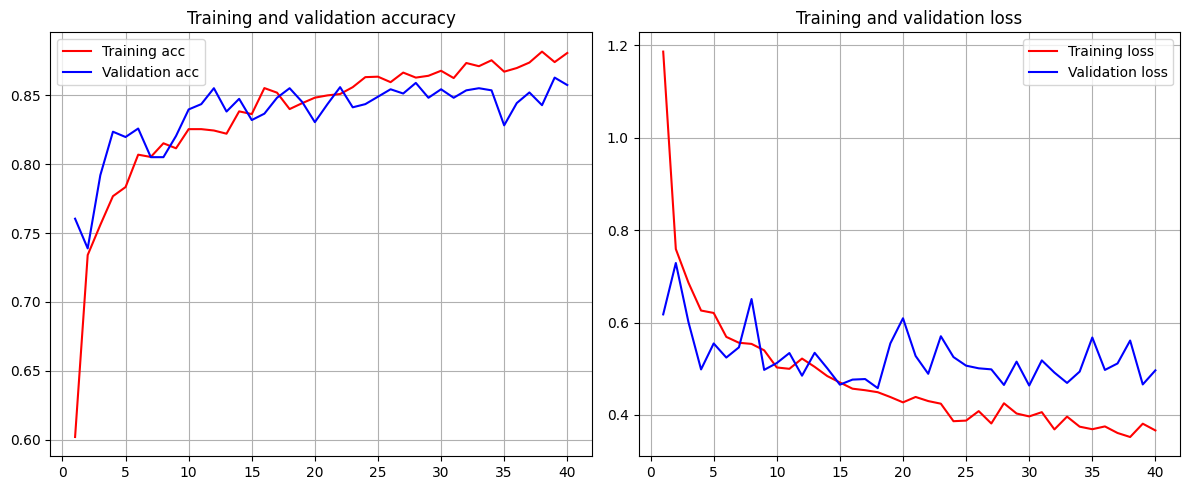

In [86]:
visualize(fine_tune_inception1_1)

## Fine Tuning with InceptionV3 (more layer and start training earlier)

Data augmentation <br>
2 Fully Connected Dense Layer <br>
lower learning rate <br>
75 epoch <br>
0.2 - 0.5  dropout rates

In [92]:
train_set,validation_set=prep_data(True,batch_size=16) # with Data Augmentation

Found 3019 images belonging to 5 classes.
Found 1298 images belonging to 5 classes.


In [93]:
base_model = InceptionV3(weights='imagenet',
    include_top=False,
    input_shape=(180, 180, 3))

In [94]:
# Freeze the layers except the last few layers
for layer in base_model.layers[:-15]:
    layer.trainable = False

In [95]:
model = Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(5, activation='softmax'))

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.00005),
    metrics=['accuracy']
)

model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 4, 4, 2048)        21802784  
                                                                 
 flatten_12 (Flatten)        (None, 32768)             0         
                                                                 
 dense_31 (Dense)            (None, 128)               4194432   
                                                                 
 dropout_18 (Dropout)        (None, 128)               0         
                                                                 
 dense_32 (Dense)            (None, 256)               33024     
                                                                 
 dropout_19 (Dropout)        (None, 256)               0         
                                                                 
 dense_33 (Dense)            (None, 5)               

In [96]:
fine_tune_inception1_2 = model.fit(
    train_set,
    epochs=40,
    validation_data=validation_set,
    )

Epoch 1/40
189/189 [==============================] - 25s 117ms/step - loss: 1.2946 - accuracy: 0.4896 - val_loss: 0.7426 - val_accuracy: 0.7373
Epoch 2/40
189/189 [==============================] - 22s 116ms/step - loss: 0.9807 - accuracy: 0.6197 - val_loss: 0.5965 - val_accuracy: 0.7943
Epoch 3/40
189/189 [==============================] - 23s 120ms/step - loss: 0.8165 - accuracy: 0.6873 - val_loss: 0.5534 - val_accuracy: 0.8028
Epoch 4/40
189/189 [==============================] - 23s 122ms/step - loss: 0.7463 - accuracy: 0.7314 - val_loss: 0.4747 - val_accuracy: 0.8282
Epoch 5/40
189/189 [==============================] - 23s 122ms/step - loss: 0.6795 - accuracy: 0.7595 - val_loss: 0.4721 - val_accuracy: 0.8336
Epoch 6/40
189/189 [==============================] - 24s 127ms/step - loss: 0.6737 - accuracy: 0.7665 - val_loss: 0.4314 - val_accuracy: 0.8467
Epoch 7/40
189/189 [==============================] - 24s 125ms/step - loss: 0.6067 - accuracy: 0.7923 - val_loss: 0.4394 - val_ac

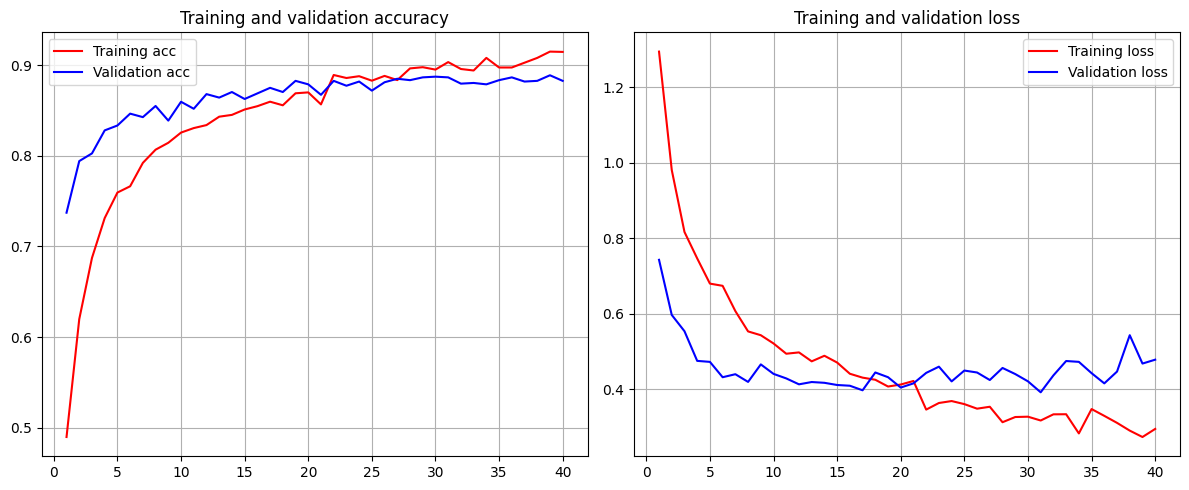

In [97]:
visualize(fine_tune_inception1_2)

accuracies seems good

## InceptionV3 with 100 epochs

In [103]:
train_set,validation_set=prep_data(True,batch_size=16) # with Data Augmentation

Found 3019 images belonging to 5 classes.
Found 1298 images belonging to 5 classes.


In [104]:
base_model = InceptionV3(weights='imagenet',
    include_top=False,
    input_shape=(180, 180, 3))

In [105]:
# Freeze the layers except the last few layers
for layer in base_model.layers[:-15]:
    layer.trainable = False

In [106]:
model = Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(5, activation='softmax'))

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.00001),
    metrics=['accuracy']
)

model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 4, 4, 2048)        21802784  
                                                                 
 flatten_14 (Flatten)        (None, 32768)             0         
                                                                 
 dense_37 (Dense)            (None, 128)               4194432   
                                                                 
 dropout_22 (Dropout)        (None, 128)               0         
                                                                 
 dense_38 (Dense)            (None, 256)               33024     
                                                                 
 dropout_23 (Dropout)        (None, 256)               0         
                                                                 
 dense_39 (Dense)            (None, 5)               

In [107]:
fine_tune_inception1_3 = model.fit(
    train_set,
    epochs=80,
    validation_data=validation_set,
    )

Epoch 1/80
189/189 [==============================] - 27s 125ms/step - loss: 1.6057 - accuracy: 0.3329 - val_loss: 1.1413 - val_accuracy: 0.5616
Epoch 2/80
189/189 [==============================] - 24s 125ms/step - loss: 1.2951 - accuracy: 0.4621 - val_loss: 0.9476 - val_accuracy: 0.6618
Epoch 3/80
189/189 [==============================] - 22s 118ms/step - loss: 1.2006 - accuracy: 0.5174 - val_loss: 0.8378 - val_accuracy: 0.6988
Epoch 4/80
189/189 [==============================] - 22s 119ms/step - loss: 1.0970 - accuracy: 0.5555 - val_loss: 0.7418 - val_accuracy: 0.7504
Epoch 5/80
189/189 [==============================] - 23s 119ms/step - loss: 1.0117 - accuracy: 0.5919 - val_loss: 0.6949 - val_accuracy: 0.7650
Epoch 6/80
189/189 [==============================] - 23s 119ms/step - loss: 0.9617 - accuracy: 0.6323 - val_loss: 0.6303 - val_accuracy: 0.7804
Epoch 7/80
189/189 [==============================] - 24s 127ms/step - loss: 0.9255 - accuracy: 0.6449 - val_loss: 0.6113 - val_ac

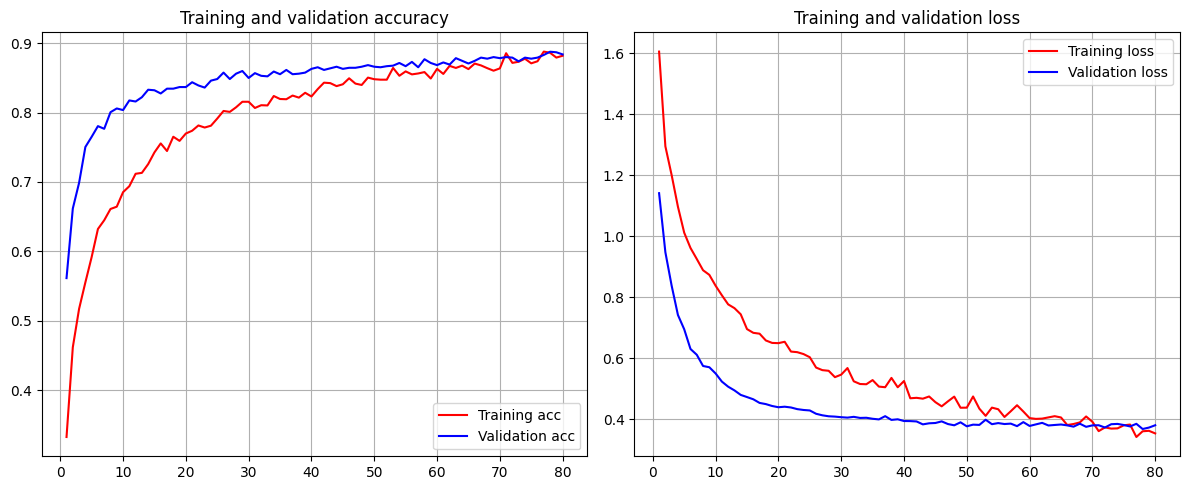

In [109]:
visualize(fine_tune_inception1_3)

pretty good results : accuracy: 0.8817 - val_accuracy: 0.8837

## Xception Feature Extraction

Data Augmentation <br>Xception pretrained model <br>
2 Fully Connected Dense Layer <br>
0.5 Dropout rate

In [8]:
from tensorflow.keras.applications import Xception

In [9]:
train_set,validation_set=prep_data(True,batch_size=16) # with Data Augmentation

Found 3019 images belonging to 5 classes.
Found 1298 images belonging to 5 classes.


In [10]:
base_model = Xception(weights='imagenet',
    include_top=False,
    input_shape=(180, 180, 3))

In [11]:
# in this part i am gonna do feature extraction therefore i set layers to untrainable
for layer in base_model.layers:
     layer.trainable = False

base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 89, 89, 32)   864         ['input_1[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 89, 89, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                                                                                           

In [12]:
model = Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(5, activation='softmax'))

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=2e-4),
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 6, 6, 2048)        20861480  
                                                                 
 flatten (Flatten)           (None, 73728)             0         
                                                                 
 dense (Dense)               (None, 128)               9437312   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 5)                 1

In [13]:
xception1_1 = model.fit(
    train_set,
    epochs=50,
    validation_data=validation_set,
    )

Epoch 1/50
189/189 [==============================] - 35s 144ms/step - loss: 1.4887 - accuracy: 0.4448 - val_loss: 0.8514 - val_accuracy: 0.6787
Epoch 2/50
189/189 [==============================] - 22s 114ms/step - loss: 1.0625 - accuracy: 0.5946 - val_loss: 0.6617 - val_accuracy: 0.7650
Epoch 3/50
189/189 [==============================] - 22s 117ms/step - loss: 0.9695 - accuracy: 0.6641 - val_loss: 0.6407 - val_accuracy: 0.7958
Epoch 4/50
189/189 [==============================] - 23s 119ms/step - loss: 0.8914 - accuracy: 0.7042 - val_loss: 0.6300 - val_accuracy: 0.7982
Epoch 5/50
189/189 [==============================] - 23s 122ms/step - loss: 0.8880 - accuracy: 0.7198 - val_loss: 0.6102 - val_accuracy: 0.8043
Epoch 6/50
189/189 [==============================] - 22s 117ms/step - loss: 0.8400 - accuracy: 0.7367 - val_loss: 0.7421 - val_accuracy: 0.7773
Epoch 7/50
189/189 [==============================] - 25s 135ms/step - loss: 0.7769 - accuracy: 0.7466 - val_loss: 0.6100 - val_ac

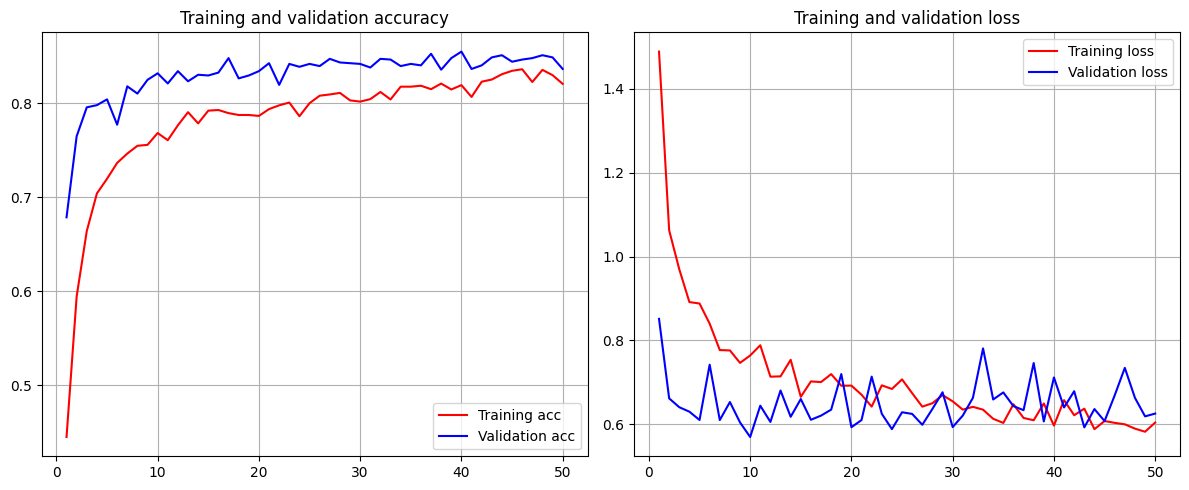

In [14]:
visualize(xception1_1)

## Xception Model without Data Augmentation

In [20]:
train_set,validation_set=prep_data(False,batch_size=16) # with Data Augmentation

Found 3019 images belonging to 5 classes.
Found 1298 images belonging to 5 classes.


In [21]:
base_model = Xception(weights='imagenet',
    include_top=False,
    input_shape=(180, 180, 3))

In [22]:
# in this part i am gonna do feature extraction therefore i set layers to untrainable
for layer in base_model.layers:
     layer.trainable = False

In [23]:

model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(5, activation='softmax'))

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=2e-4),
    metrics=['accuracy']
)

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 6, 6, 2048)        20861480  
                                                                 
 flatten_2 (Flatten)         (None, 73728)             0         
                                                                 
 dense_5 (Dense)             (None, 32)                2359328   
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_6 (Dense)             (None, 5)                 165       
                                                                 
Total params: 23,220,973
Trainable params: 2,359,493
Non-trainable params: 20,861,480
_________________________________________________________________


In [24]:
xception1_3 = model.fit(
    train_set,
    epochs=30,
    validation_data=validation_set,
    )

Epoch 1/30
189/189 [==============================] - 16s 71ms/step - loss: 1.1091 - accuracy: 0.6221 - val_loss: 0.5566 - val_accuracy: 0.7997
Epoch 2/30
189/189 [==============================] - 13s 67ms/step - loss: 0.7556 - accuracy: 0.7426 - val_loss: 0.6293 - val_accuracy: 0.7997
Epoch 3/30
189/189 [==============================] - 13s 67ms/step - loss: 0.6686 - accuracy: 0.7854 - val_loss: 0.6137 - val_accuracy: 0.8112
Epoch 4/30
189/189 [==============================] - 13s 67ms/step - loss: 0.6081 - accuracy: 0.8003 - val_loss: 0.5675 - val_accuracy: 0.8243
Epoch 5/30
189/189 [==============================] - 13s 67ms/step - loss: 0.5062 - accuracy: 0.8235 - val_loss: 0.5602 - val_accuracy: 0.8382
Epoch 6/30
189/189 [==============================] - 13s 67ms/step - loss: 0.4911 - accuracy: 0.8400 - val_loss: 0.6081 - val_accuracy: 0.8529
Epoch 7/30
189/189 [==============================] - 13s 67ms/step - loss: 0.4569 - accuracy: 0.8420 - val_loss: 0.6963 - val_accuracy:

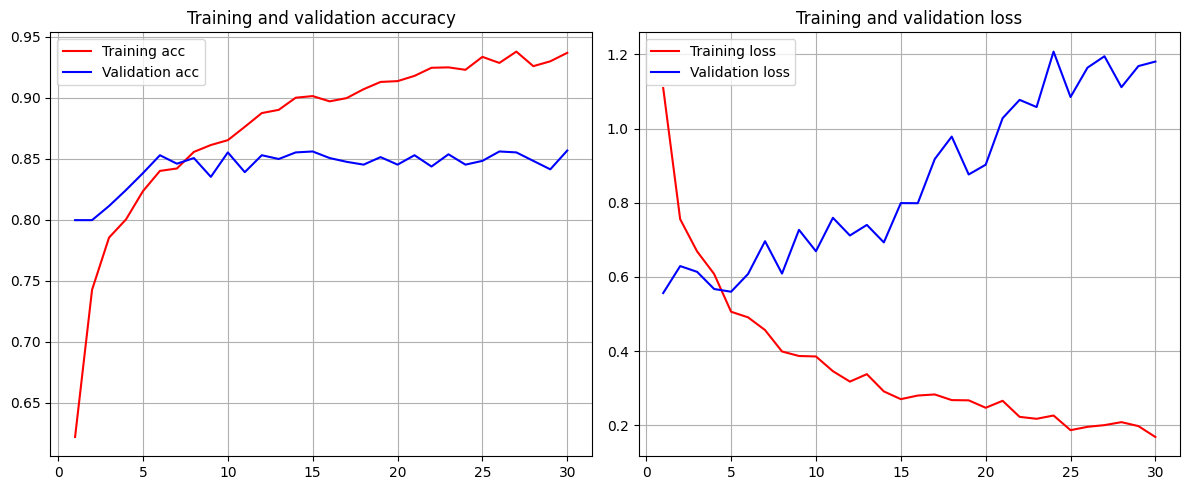

In [25]:
visualize(xception1_3)

overfitting occured , below there is same model i will try to prevent overfitting

No data augmentation <br>
Lower learning rate <br>
more epoch <br>
0.6 dropout rate

In [37]:
train_set,validation_set=prep_data(False,batch_size=16) # with Data Augmentation

Found 3019 images belonging to 5 classes.
Found 1298 images belonging to 5 classes.


In [38]:
base_model = Xception(weights='imagenet',
    include_top=False,
    input_shape=(180, 180, 3))

In [39]:
# in this part i am gonna do feature extraction therefore i set layers to untrainable
for layer in base_model.layers:
     layer.trainable = False

In [40]:

model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.7))
model.add(layers.Dense(5, activation='softmax'))

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.000008),
    metrics=['accuracy']
)

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 6, 6, 2048)        20861480  
                                                                 
 flatten_5 (Flatten)         (None, 73728)             0         
                                                                 
 dense_11 (Dense)            (None, 32)                2359328   
                                                                 
 dropout_6 (Dropout)         (None, 32)                0         
                                                                 
 dense_12 (Dense)            (None, 5)                 165       
                                                                 
Total params: 23,220,973
Trainable params: 2,359,493
Non-trainable params: 20,861,480
_________________________________________________________________


In [41]:
xception1_4 = model.fit(
    train_set,
    epochs=60,
    validation_data=validation_set,
    )

Epoch 1/60
189/189 [==============================] - 16s 71ms/step - loss: 1.3918 - accuracy: 0.4068 - val_loss: 0.8919 - val_accuracy: 0.7419
Epoch 2/60
189/189 [==============================] - 13s 67ms/step - loss: 1.0595 - accuracy: 0.5747 - val_loss: 0.7018 - val_accuracy: 0.7835
Epoch 3/60
189/189 [==============================] - 13s 67ms/step - loss: 0.9219 - accuracy: 0.6227 - val_loss: 0.6261 - val_accuracy: 0.8089
Epoch 4/60
189/189 [==============================] - 13s 68ms/step - loss: 0.8354 - accuracy: 0.6708 - val_loss: 0.5627 - val_accuracy: 0.8097
Epoch 5/60
189/189 [==============================] - 13s 68ms/step - loss: 0.7972 - accuracy: 0.6956 - val_loss: 0.5317 - val_accuracy: 0.8228
Epoch 6/60
189/189 [==============================] - 13s 67ms/step - loss: 0.7600 - accuracy: 0.6992 - val_loss: 0.5106 - val_accuracy: 0.8336
Epoch 7/60
189/189 [==============================] - 13s 68ms/step - loss: 0.7447 - accuracy: 0.7132 - val_loss: 0.4961 - val_accuracy:

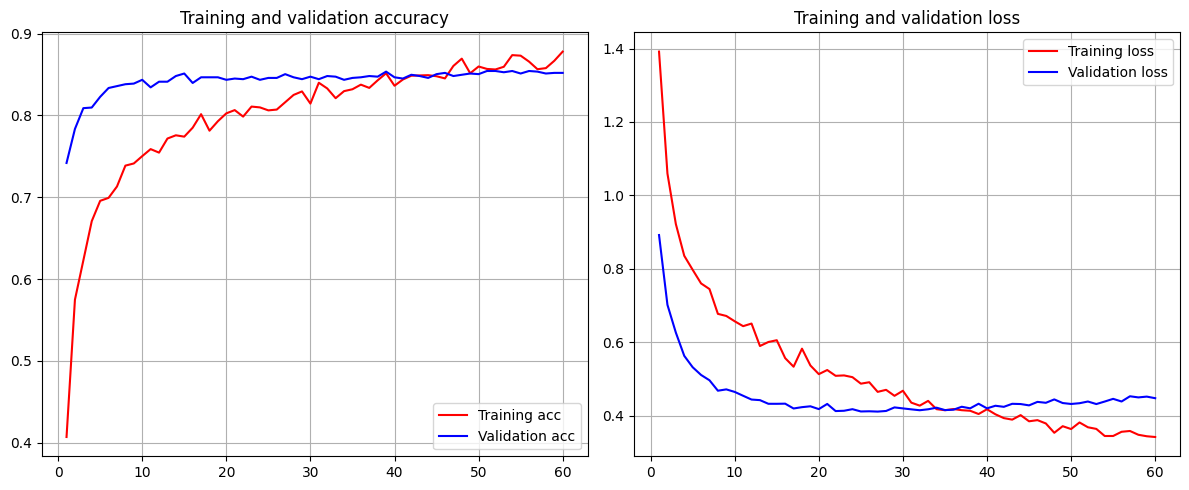

In [43]:
visualize(xception1_4)

accuracy: 0.8781 - val_accuracy: 0.8521 , this model prevents overfitting

## Fine Tune Xception Model

Data Augmentation

In [44]:
train_set,validation_set=prep_data(True,batch_size=16) # with Data Augmentation

Found 3019 images belonging to 5 classes.
Found 1298 images belonging to 5 classes.


In [45]:
base_model = Xception(weights='imagenet',
    include_top=False,
    input_shape=(180, 180, 3))

In [46]:
# Freeze the layers except the last few layers
for layer in base_model.layers[:-15]:
    layer.trainable = False

In [47]:
model = Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(5, activation='softmax'))

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
    metrics=['accuracy']
)

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 6, 6, 2048)        20861480  
                                                                 
 flatten_6 (Flatten)         (None, 73728)             0         
                                                                 
 dense_13 (Dense)            (None, 64)                4718656   
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_14 (Dense)            (None, 5)                 325       
                                                                 
Total params: 25,580,461
Trainable params: 11,507,365
Non-trainable params: 14,073,096
_________________________________________________________________


In [48]:
xception2_1 = model.fit(
    train_set,
    epochs=50,
    validation_data=validation_set,
    )

Epoch 1/50
189/189 [==============================] - 27s 125ms/step - loss: 0.9626 - accuracy: 0.6476 - val_loss: 0.9382 - val_accuracy: 0.7535
Epoch 2/50
189/189 [==============================] - 24s 128ms/step - loss: 0.5948 - accuracy: 0.7940 - val_loss: 0.3891 - val_accuracy: 0.8737
Epoch 3/50
189/189 [==============================] - 23s 122ms/step - loss: 0.4841 - accuracy: 0.8453 - val_loss: 0.3876 - val_accuracy: 0.8921
Epoch 4/50
189/189 [==============================] - 23s 124ms/step - loss: 0.4113 - accuracy: 0.8735 - val_loss: 0.3819 - val_accuracy: 0.8891
Epoch 5/50
189/189 [==============================] - 22s 119ms/step - loss: 0.3534 - accuracy: 0.8880 - val_loss: 0.4110 - val_accuracy: 0.8914
Epoch 6/50
189/189 [==============================] - 22s 117ms/step - loss: 0.3313 - accuracy: 0.8940 - val_loss: 0.3946 - val_accuracy: 0.9006
Epoch 7/50
189/189 [==============================] - 22s 118ms/step - loss: 0.2977 - accuracy: 0.9059 - val_loss: 0.4086 - val_ac

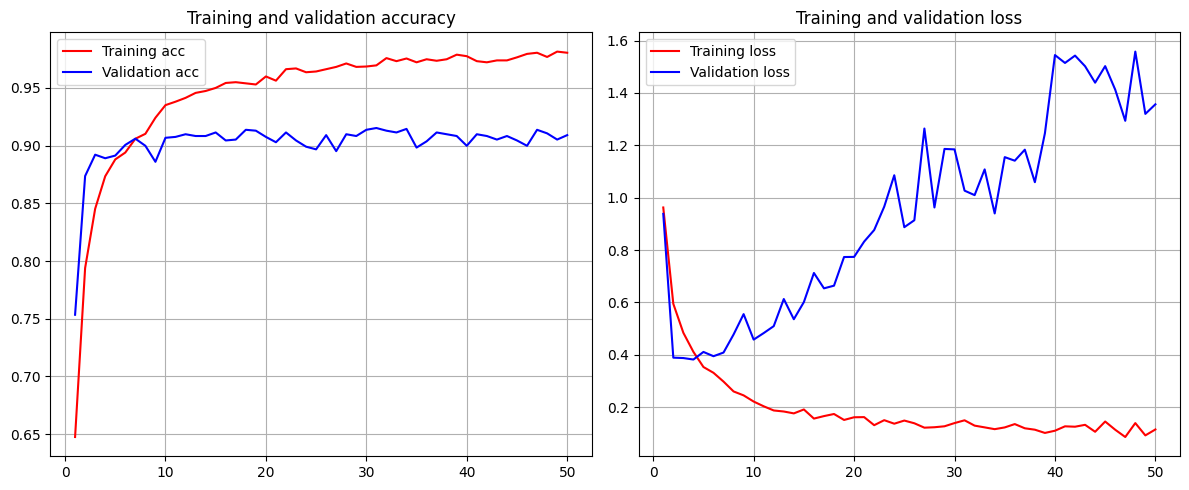

In [49]:
visualize(xception2_1)

this model is overfitting , i will try to prevent overfitting

This is a model for prevent overfitting ( nearly same with above model ) <br>
Data Augmentation <br>
train last 15 layer of Xception <br>
0.00004 learning rate

In [56]:
train_set,validation_set=prep_data(True,batch_size=16) # with Data Augmentation

Found 3019 images belonging to 5 classes.
Found 1298 images belonging to 5 classes.


In [57]:
base_model = Xception(weights='imagenet',
    include_top=False,
    input_shape=(180, 180, 3))

In [58]:
# Freeze the layers except the last few layers
for layer in base_model.layers[:-15]:
    layer.trainable = False

In [59]:
model = Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.7))
model.add(layers.Dense(5, activation='softmax'))

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.00004),
    metrics=['accuracy']
)

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 6, 6, 2048)        20861480  
                                                                 
 flatten_8 (Flatten)         (None, 73728)             0         
                                                                 
 dense_17 (Dense)            (None, 64)                4718656   
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 dense_18 (Dense)            (None, 5)                 325       
                                                                 
Total params: 25,580,461
Trainable params: 11,507,365
Non-trainable params: 14,073,096
_________________________________________________________________


In [60]:
xception2_2 = model.fit(
    train_set,
    epochs=20,
    validation_data=validation_set,
    )

Epoch 1/20
189/189 [==============================] - 26s 122ms/step - loss: 1.2674 - accuracy: 0.4952 - val_loss: 0.6183 - val_accuracy: 0.7712
Epoch 2/20
189/189 [==============================] - 22s 116ms/step - loss: 0.8464 - accuracy: 0.6969 - val_loss: 0.5372 - val_accuracy: 0.8136
Epoch 3/20
189/189 [==============================] - 22s 117ms/step - loss: 0.7176 - accuracy: 0.7440 - val_loss: 0.4356 - val_accuracy: 0.8436
Epoch 4/20
189/189 [==============================] - 22s 116ms/step - loss: 0.6248 - accuracy: 0.7857 - val_loss: 0.4137 - val_accuracy: 0.8667
Epoch 5/20
189/189 [==============================] - 22s 117ms/step - loss: 0.5838 - accuracy: 0.8099 - val_loss: 0.3791 - val_accuracy: 0.8844
Epoch 6/20
189/189 [==============================] - 22s 115ms/step - loss: 0.5556 - accuracy: 0.8182 - val_loss: 0.3587 - val_accuracy: 0.8860
Epoch 7/20
189/189 [==============================] - 22s 117ms/step - loss: 0.5149 - accuracy: 0.8347 - val_loss: 0.3442 - val_ac

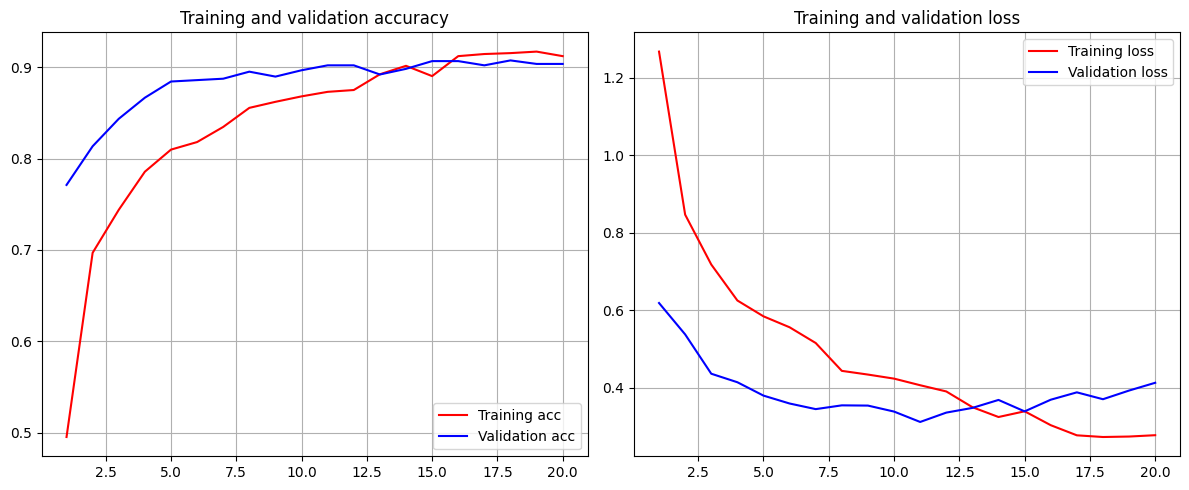

In [75]:
visualize(xception2_2)

accuracy: 0.9122  - val_accuracy: 0.9037 , results seems pretty good

## Same Model but with 2  Fully connected Layer

In [89]:
train_set,validation_set=prep_data(True,batch_size=16) # with Data Augmentation

Found 3019 images belonging to 5 classes.
Found 1298 images belonging to 5 classes.


In [90]:
base_model = Xception(weights='imagenet',
    include_top=False,
    input_shape=(180, 180, 3))

In [91]:
# Freeze the layers except the last few layers
for layer in base_model.layers[:-30]:
    layer.trainable = False

In [92]:
model = Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(5, activation='softmax'))

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.00002),
    metrics=['accuracy']
)

model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 6, 6, 2048)        20861480  
                                                                 
 flatten_13 (Flatten)        (None, 73728)             0         
                                                                 
 dense_29 (Dense)            (None, 256)               18874624  
                                                                 
 dropout_16 (Dropout)        (None, 256)               0         
                                                                 
 dense_30 (Dense)            (None, 512)               131584    
                                                                 
 dropout_17 (Dropout)        (None, 512)               0         
                                                                 
 dense_31 (Dense)            (None, 5)               

In [93]:
xception2_3 = model.fit(
    train_set,
    epochs=20,
    validation_data=validation_set,
    )

Epoch 1/20
189/189 [==============================] - 28s 130ms/step - loss: 1.3156 - accuracy: 0.4541 - val_loss: 0.7136 - val_accuracy: 0.7342
Epoch 2/20
189/189 [==============================] - 24s 127ms/step - loss: 0.8677 - accuracy: 0.6757 - val_loss: 0.5577 - val_accuracy: 0.7951
Epoch 3/20
189/189 [==============================] - 24s 124ms/step - loss: 0.7071 - accuracy: 0.7430 - val_loss: 0.4350 - val_accuracy: 0.8475
Epoch 4/20
189/189 [==============================] - 24s 125ms/step - loss: 0.6172 - accuracy: 0.7784 - val_loss: 0.4118 - val_accuracy: 0.8567
Epoch 5/20
189/189 [==============================] - 23s 124ms/step - loss: 0.5458 - accuracy: 0.8099 - val_loss: 0.4003 - val_accuracy: 0.8667
Epoch 6/20
189/189 [==============================] - 24s 125ms/step - loss: 0.5083 - accuracy: 0.8264 - val_loss: 0.3941 - val_accuracy: 0.8636
Epoch 7/20
189/189 [==============================] - 24s 125ms/step - loss: 0.4798 - accuracy: 0.8380 - val_loss: 0.3900 - val_ac

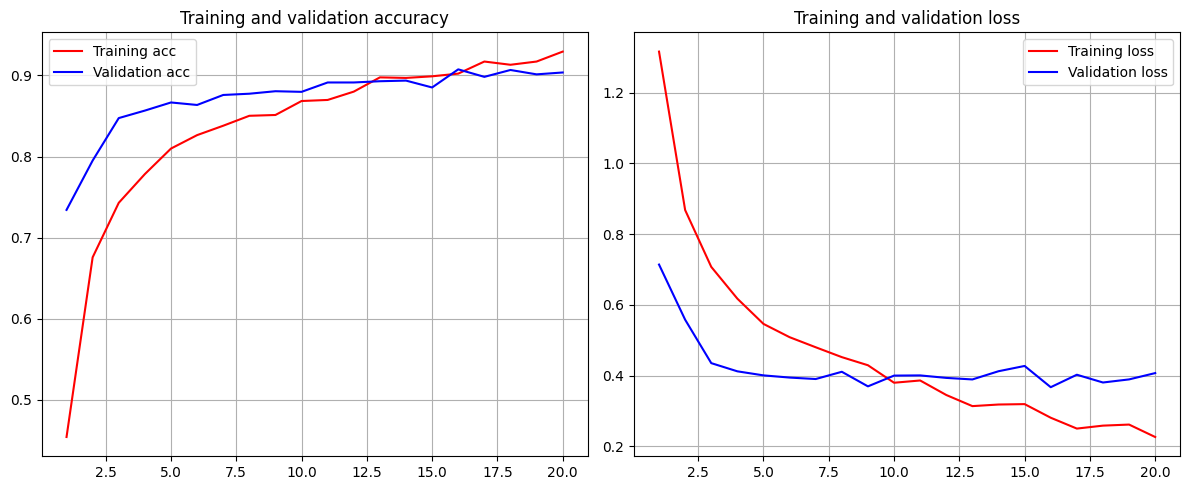

In [95]:
visualize(xception2_3)

## Visualizing what Convnet Learn

### Visualizing intermediate activations

In [96]:
train_set,validation_set=prep_data(True,batch_size=16) # create datasets ( augmented)

Found 3019 images belonging to 5 classes.
Found 1298 images belonging to 5 classes.


In [97]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(180, 180, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())

model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(5, activation='softmax'))

model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_56 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_57 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_58 (Conv2D)          (None, 41, 41, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 20, 20, 128)    

In [98]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.00005),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

In [99]:
history1_9 = model.fit(
    train_set,
    epochs=60,
    validation_data=validation_set,)

Epoch 1/60
189/189 [==============================] - 24s 118ms/step - loss: 1.4768 - accuracy: 0.3269 - val_loss: 1.3251 - val_accuracy: 0.4083
Epoch 2/60
189/189 [==============================] - 21s 110ms/step - loss: 1.2771 - accuracy: 0.4306 - val_loss: 1.1435 - val_accuracy: 0.4931
Epoch 3/60
189/189 [==============================] - 21s 114ms/step - loss: 1.2195 - accuracy: 0.4667 - val_loss: 1.1359 - val_accuracy: 0.5100
Epoch 4/60
189/189 [==============================] - 23s 119ms/step - loss: 1.1748 - accuracy: 0.5065 - val_loss: 1.2052 - val_accuracy: 0.4869
Epoch 5/60
189/189 [==============================] - 21s 110ms/step - loss: 1.1517 - accuracy: 0.5257 - val_loss: 1.0383 - val_accuracy: 0.5878
Epoch 6/60
189/189 [==============================] - 22s 117ms/step - loss: 1.1170 - accuracy: 0.5472 - val_loss: 1.0198 - val_accuracy: 0.5932
Epoch 7/60
189/189 [==============================] - 21s 112ms/step - loss: 1.0852 - accuracy: 0.5608 - val_loss: 1.0195 - val_ac

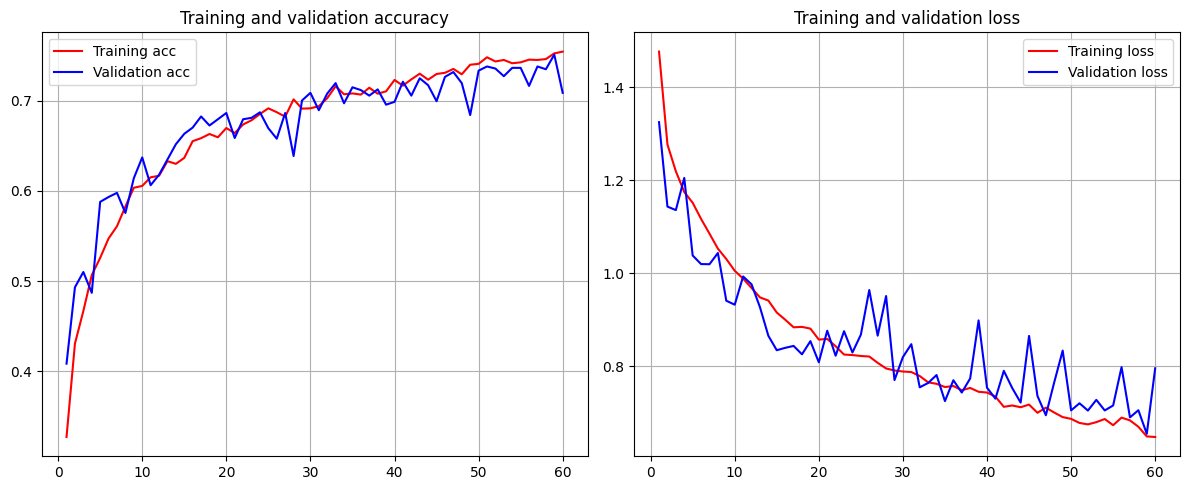

In [101]:
visualize(history1_9)

i trained this model for visualizing what layers  see 

### Visualizing intermediate activations

Above i train one more model for this part 

In [7]:
from keras.preprocessing import image
from keras.models import load_model
import numpy as np

In [8]:
label_dict={0:'daisy',1: 'dandelion', 2:'rose', 3:'sunflower', 4:'tulip'}

In [9]:
img = image.load_img("gul.jpg", target_size=(180, 180))  # Hedef boyutu modele göre ayarlayın
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0  # Görüntüyü normalize etmek için

In [105]:
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)[0]
print(label_dict[predicted_class])

tulip


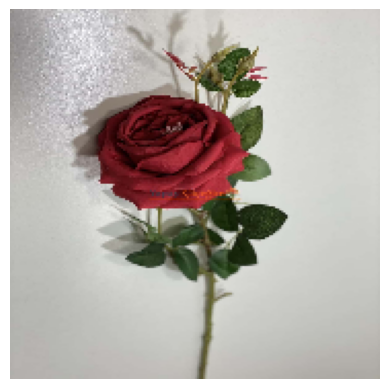

In [106]:
import matplotlib.pyplot as plt
plt.imshow(img_array[0])  
plt.axis('off')  
plt.show()


In [107]:
from keras import models

# Extracts the outputs of the top eight layers
layer_outputs = [layer.output for layer in model.layers[:8]]

# creates a model that will return these outputs, given the model input
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [108]:
activations = activation_model.predict(img_array)

In [109]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 178, 178, 32)


#### activation of the first convolution layer for the rose image input

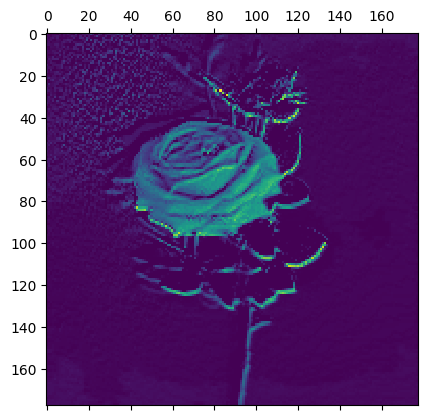

In [110]:
import matplotlib.pyplot as plt
plt.matshow(first_layer_activation[0, :, :, 2], cmap='viridis')

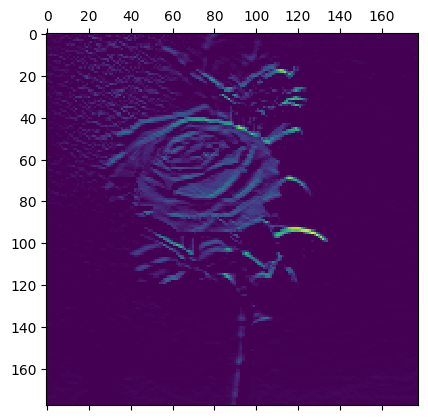

In [115]:
# 10. layer
plt.matshow(first_layer_activation[0, :, :, 10], cmap='viridis')

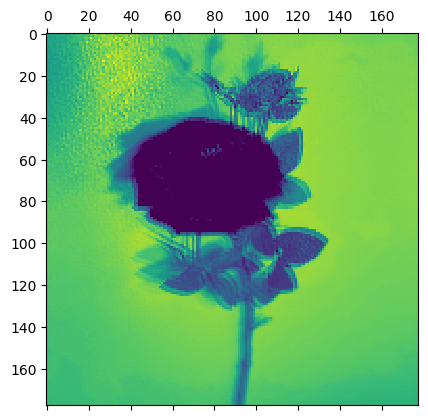

In [117]:
# 11. layer
plt.matshow(first_layer_activation[0, :, :, 20], cmap='viridis')

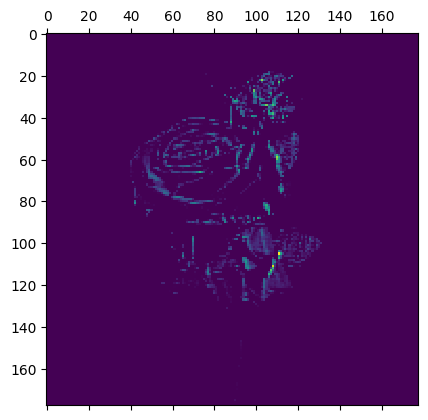

In [118]:
# 31. layer
plt.matshow(first_layer_activation[0, :, :, 31], cmap='viridis')

C:\Users\sirom\AppData\Local\Temp\ipykernel_11140\264525031.py:17: RuntimeWarning: invalid value encountered in divide
  channel_image /= channel_image.std()
C:\Users\sirom\AppData\Local\Temp\ipykernel_11140\264525031.py:20: RuntimeWarning: invalid value encountered in cast
  channel_image = np.clip(channel_image, 0, 255).astype('uint8')


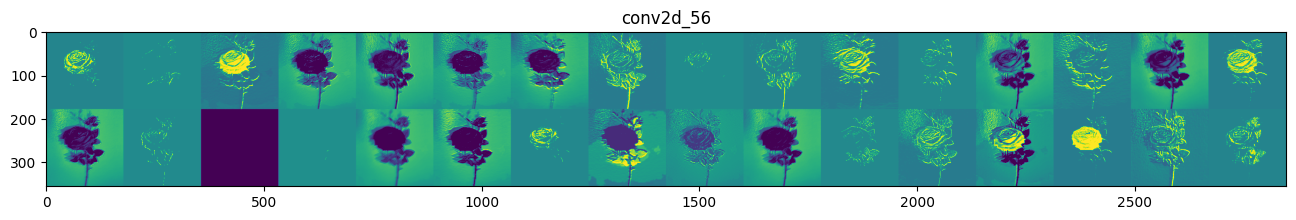

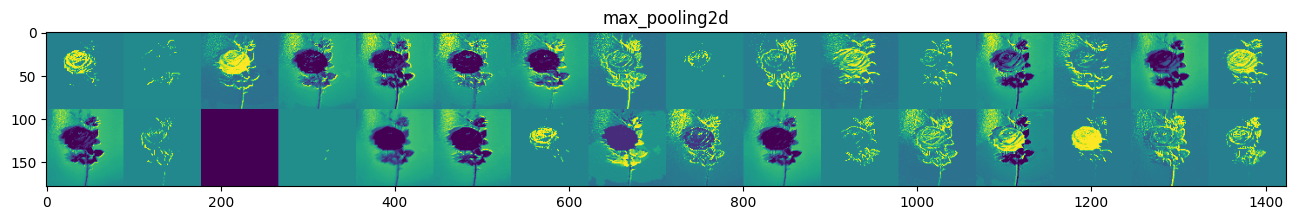

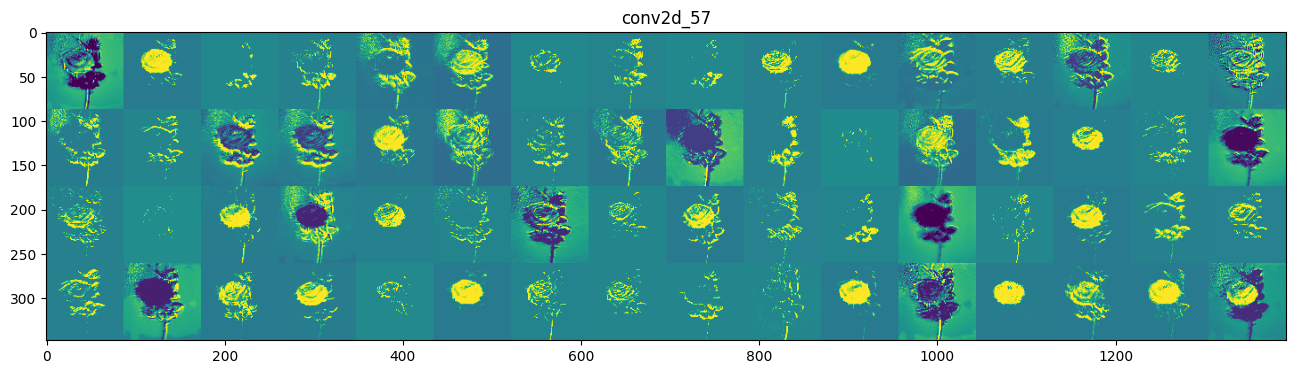

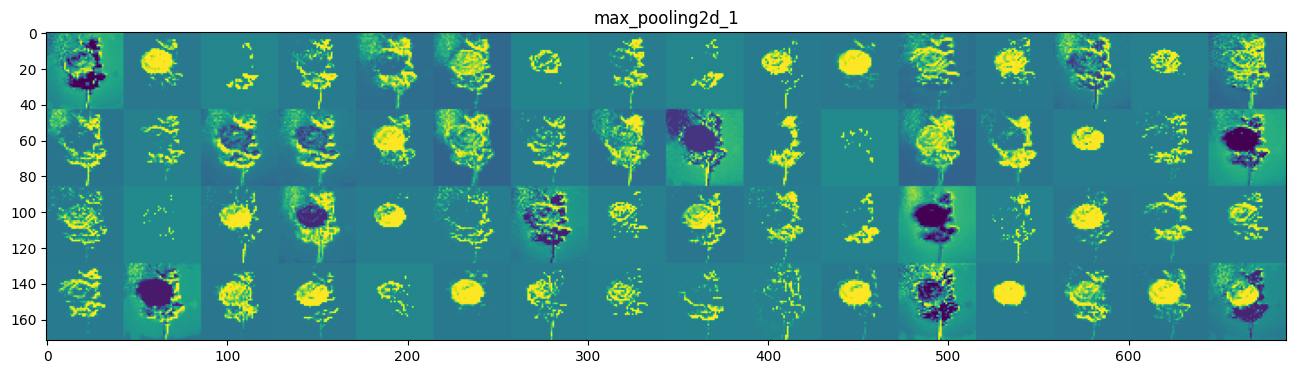

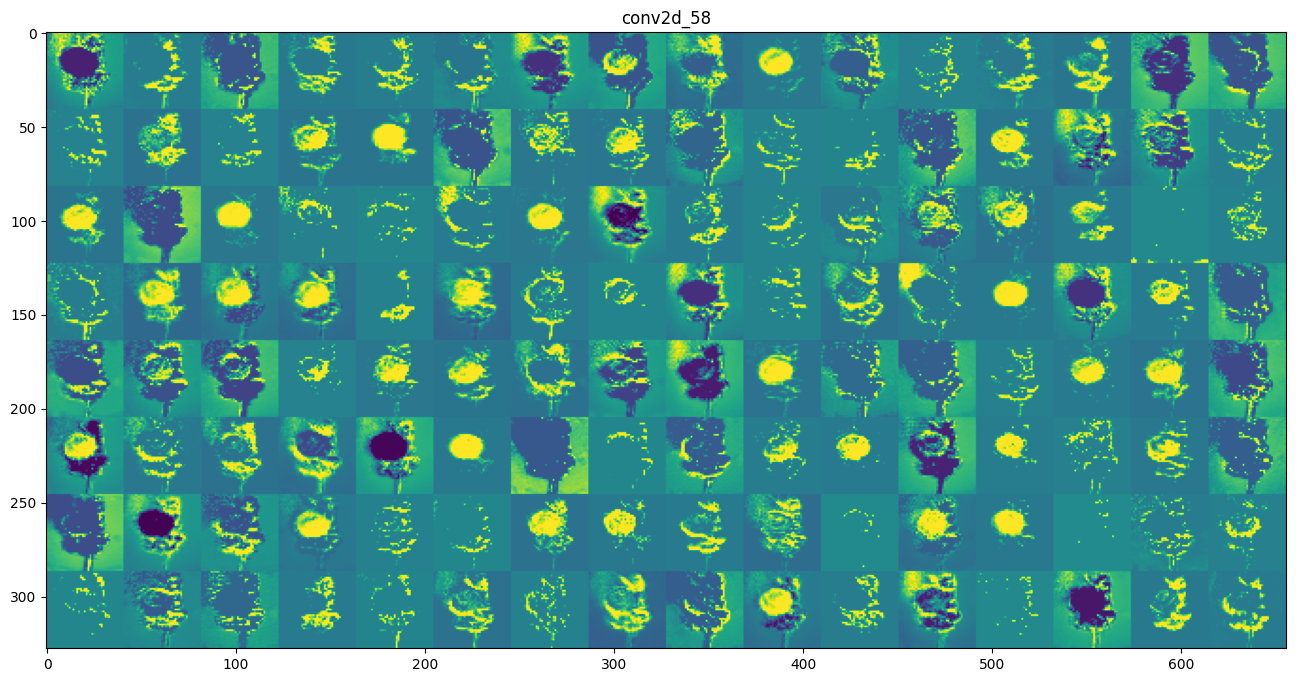

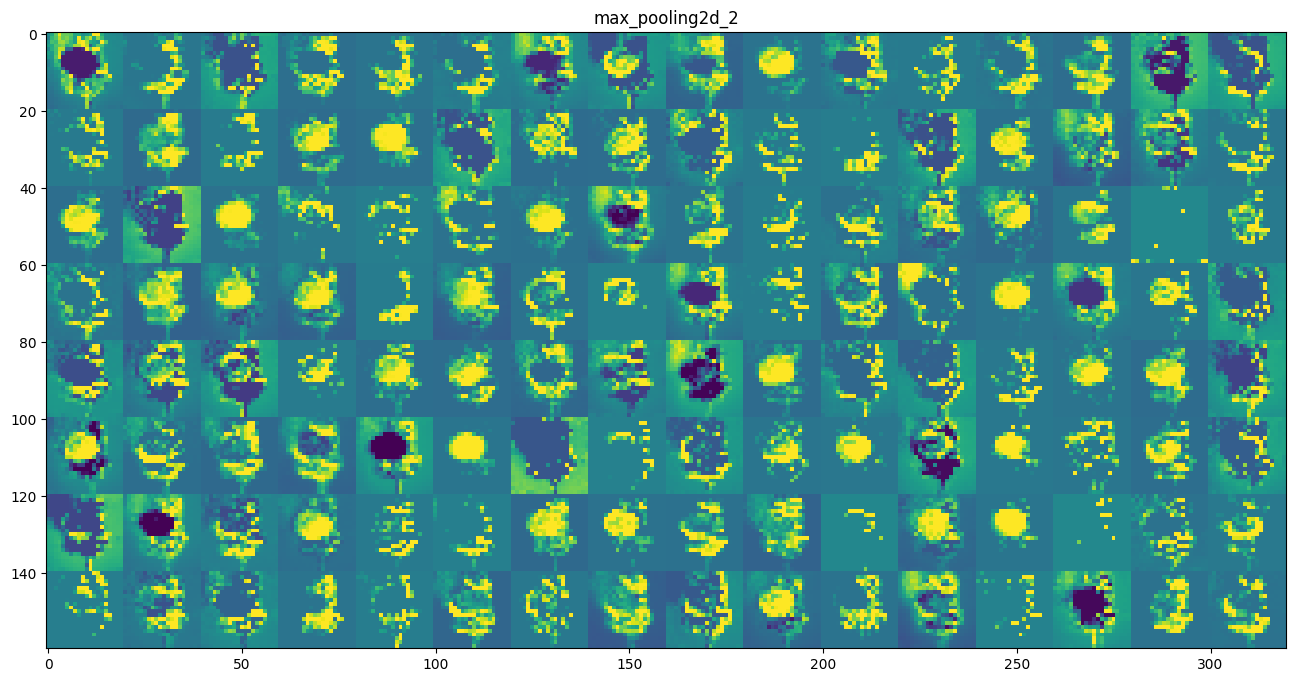

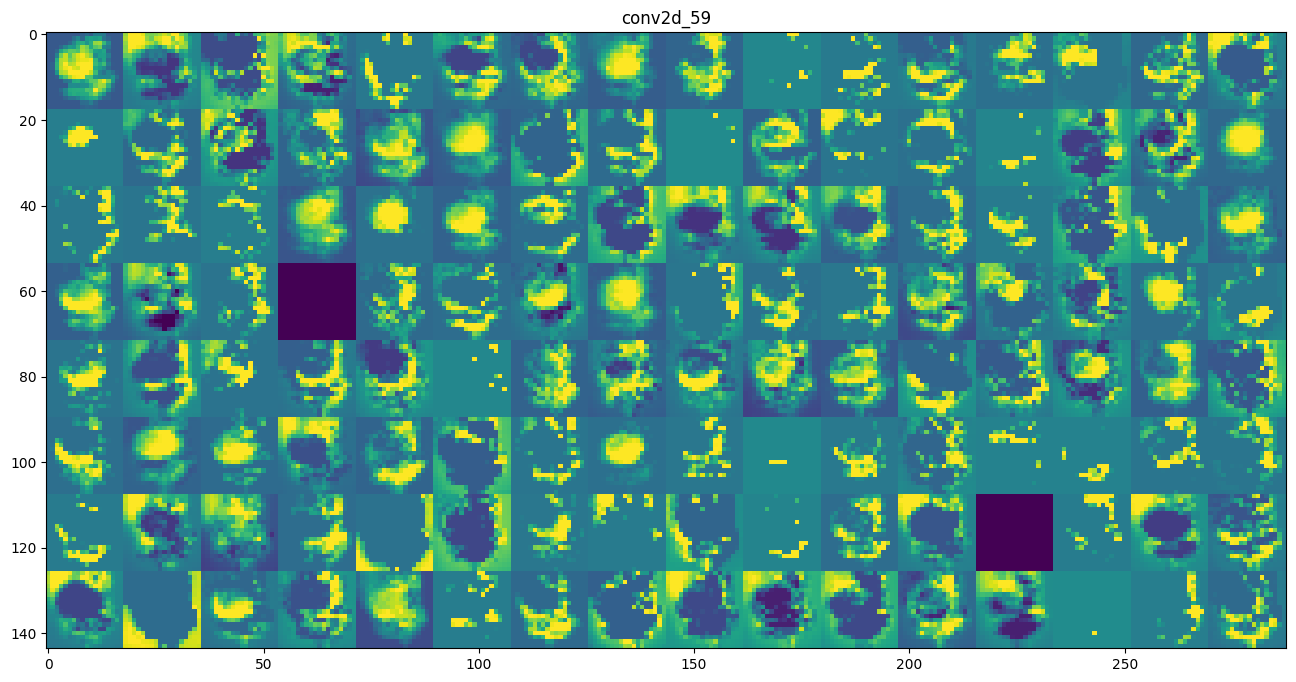

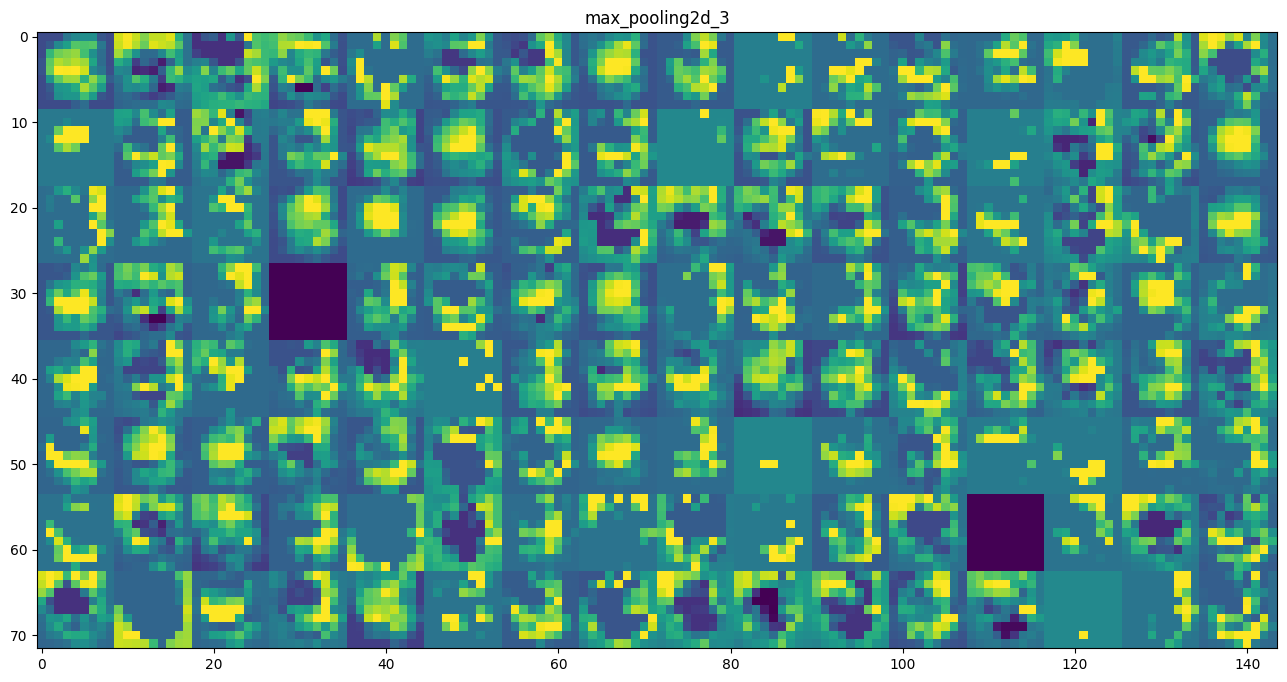

In [114]:
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)
    
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
            :, :,
            col * images_per_row + row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
            row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
    scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

## HeatMap

In [12]:
img = image.load_img("gul.jpg", target_size=(224, 224))  # Hedef boyutu modele göre ayarlayın
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0  # Görüntüyü normalize etmek için

In [13]:
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import load_model

from tensorflow.keras import preprocessing
from tensorflow.keras import backend as K
from tensorflow.keras import models

import tensorflow as tf
import numpy as np

image_size = 224

# Load pre-trained Keras model and the image to classify
model = tf.keras.applications.vgg16.VGG16()



conv_layer = model.get_layer("block5_conv3")
heatmap_model = models.Model([model.inputs], [conv_layer.output, model.output])

# Get gradient of the winner class w.r.t. the output of the (last) conv. layer
with tf.GradientTape() as gtape:
    conv_output, predictions = heatmap_model(img_array)
    loss = predictions[:, np.argmax(predictions[0])]
    grads = gtape.gradient(loss, conv_output)
    pooled_grads = K.mean(grads, axis=(0, 1, 2))

heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_output), axis=-1)
heatmap = np.maximum(heatmap, 0)
max_heat = np.max(heatmap)
if max_heat == 0:
    max_heat = 1e-10
heatmap /= max_heat

print(heatmap.shape)

(1, 14, 14)


In [14]:
import matplotlib.pyplot as plt
hm=np.squeeze(heatmap)
hm.shape

(14, 14)

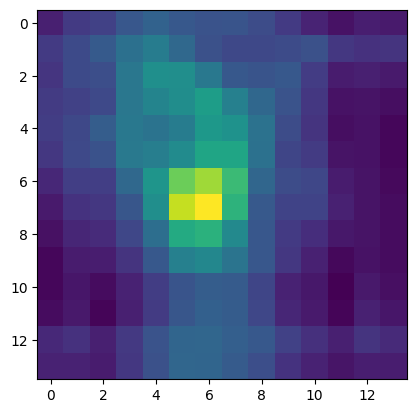

In [15]:
plt.imshow(hm)


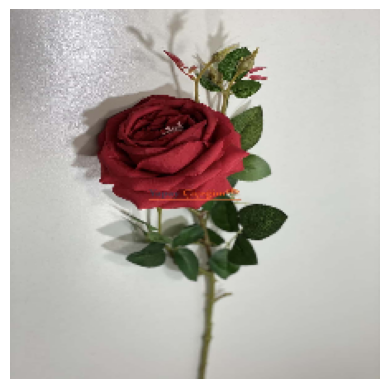

In [16]:
import matplotlib.pyplot as plt
plt.imshow(img_array[0])  
plt.axis('off')  
plt.show()
